# Results

### Setup

In [1]:
import tensorflow as tf
import utility.initialize_tf
from custom_models.gamornet_keras_module import *
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from utility.display_prediction_results import *
from utility.data_preprocessing import *
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from utility.results_helper import *
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

mpl.rcParams['figure.figsize'] = [12, 12]
mpl.rcParams['figure.dpi'] = 144



2.5.0
2.5.0


# Datasets

## NA10 Dataset

E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'NYU-DR4_Object_Tag'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'g-r'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


(2723, 100, 100)


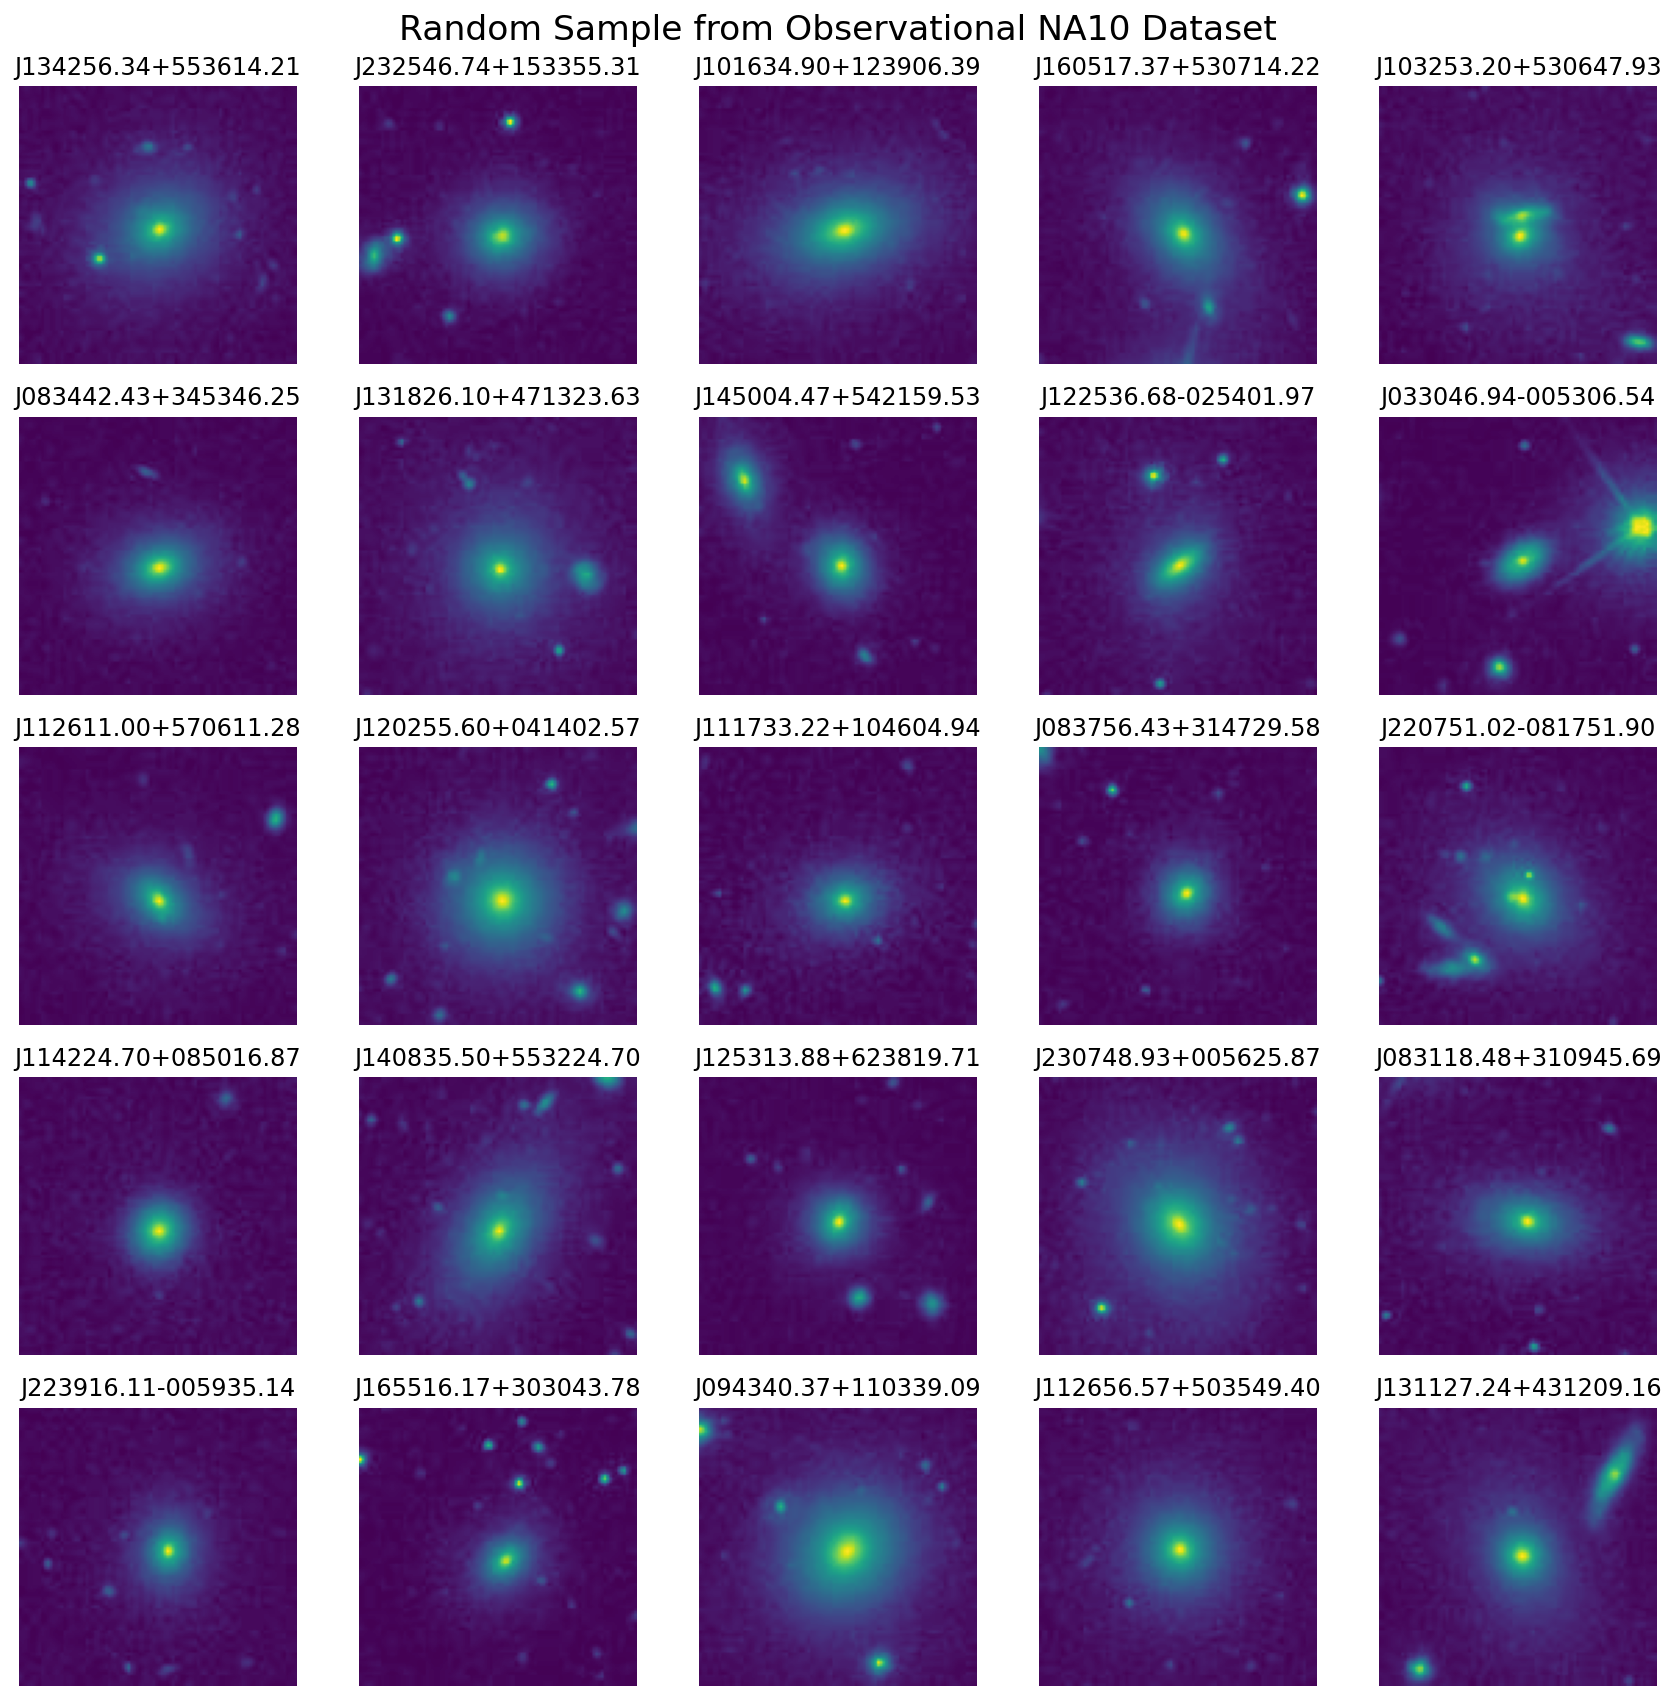

In [2]:
x_nair, y_nair, metadata_nair = load_hdf5_data(name="nair_abraham_2010_hdf5")
x_nair = np.expand_dims(x_nair, axis=3)
y_nair = np.expand_dims(y_nair, axis=1)

plot_dataset(x_nair, metadata=metadata_nair, title="Random Sample from Observational NA10 Dataset")
#display(metadata_nair['NYU-DR4_Object_Tag'])

## CALIFA Dataset

(79, 100, 100)
(100, 100, 1)
3


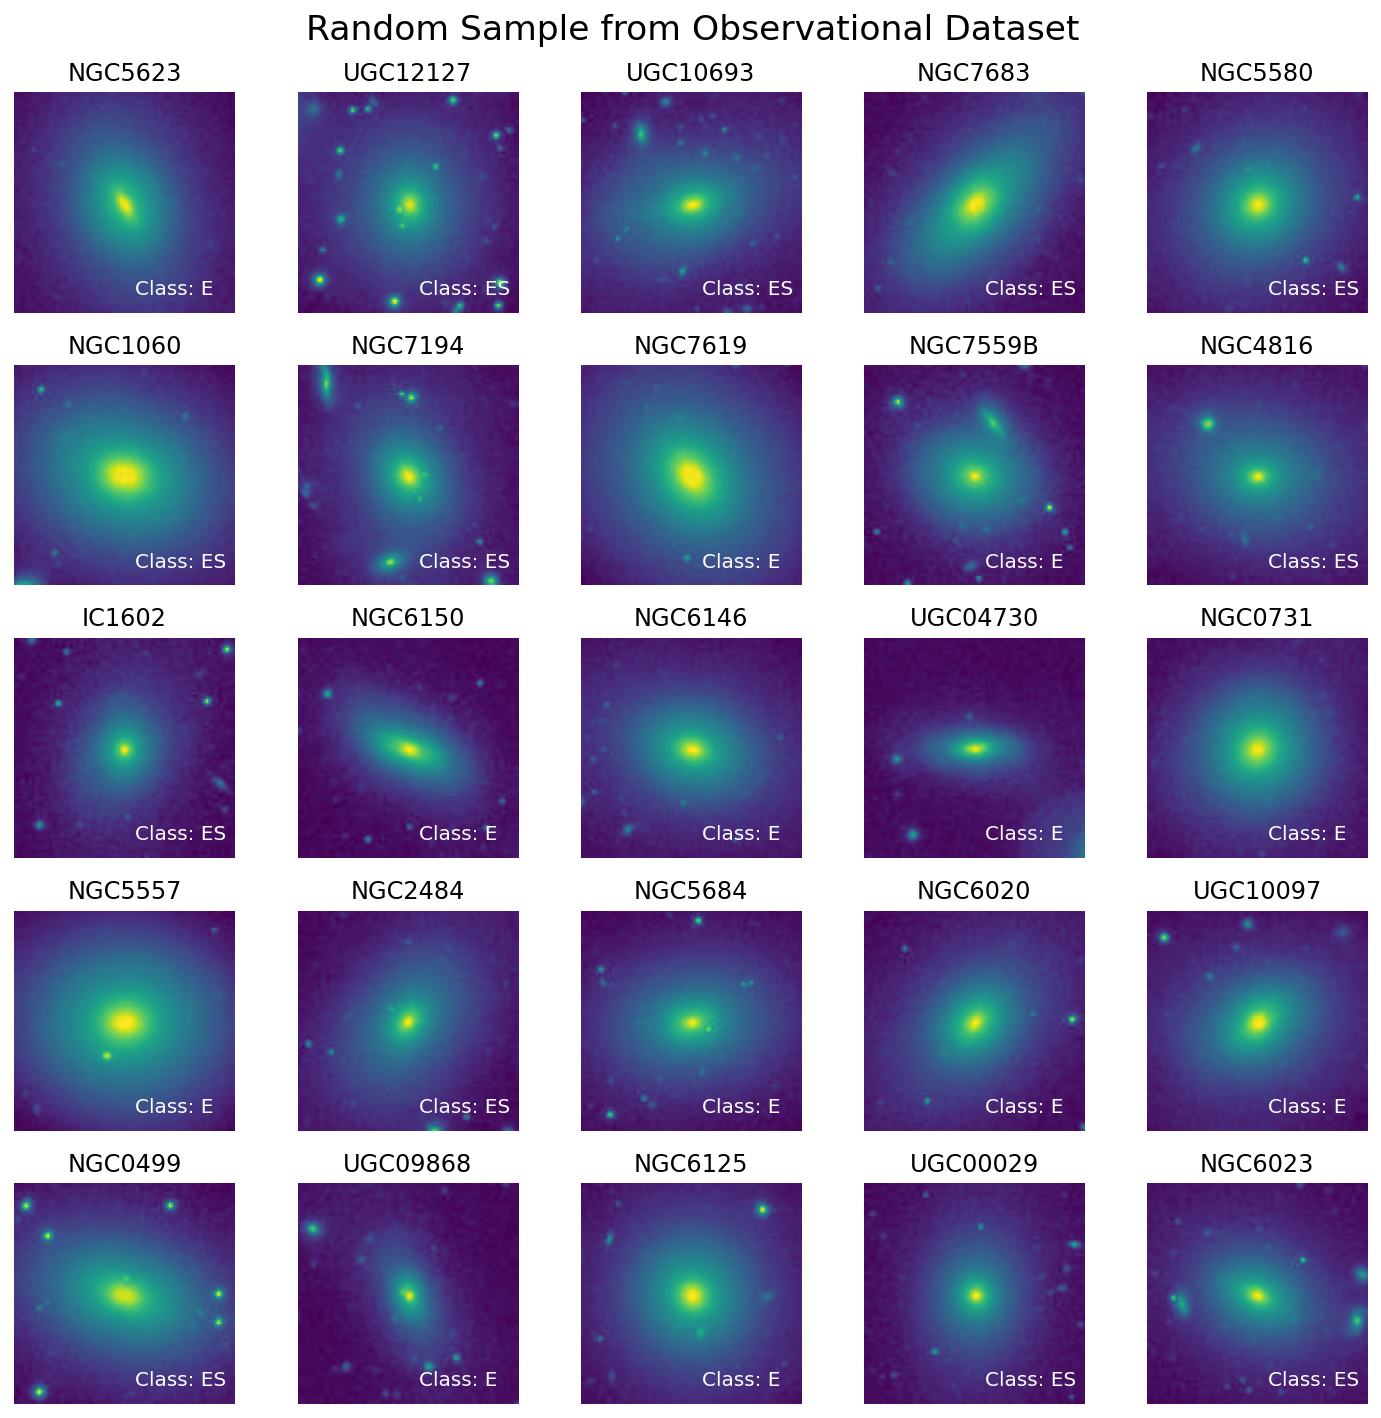

In [3]:
mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 144

x_califa, y_califa, metadata_califa = load_hdf5_data("califa_s_1.0")
x_califa = np.expand_dims(x_califa, axis=3)
y_califa = np.expand_dims(y_califa, axis=1)
input_shape = x_califa.shape[1:]
print(input_shape)

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=2021)
print(sss.get_n_splits(x_califa, y_califa))
plot_dataset(x_califa, metadata=metadata_califa, title="Random Sample from Observational Dataset")

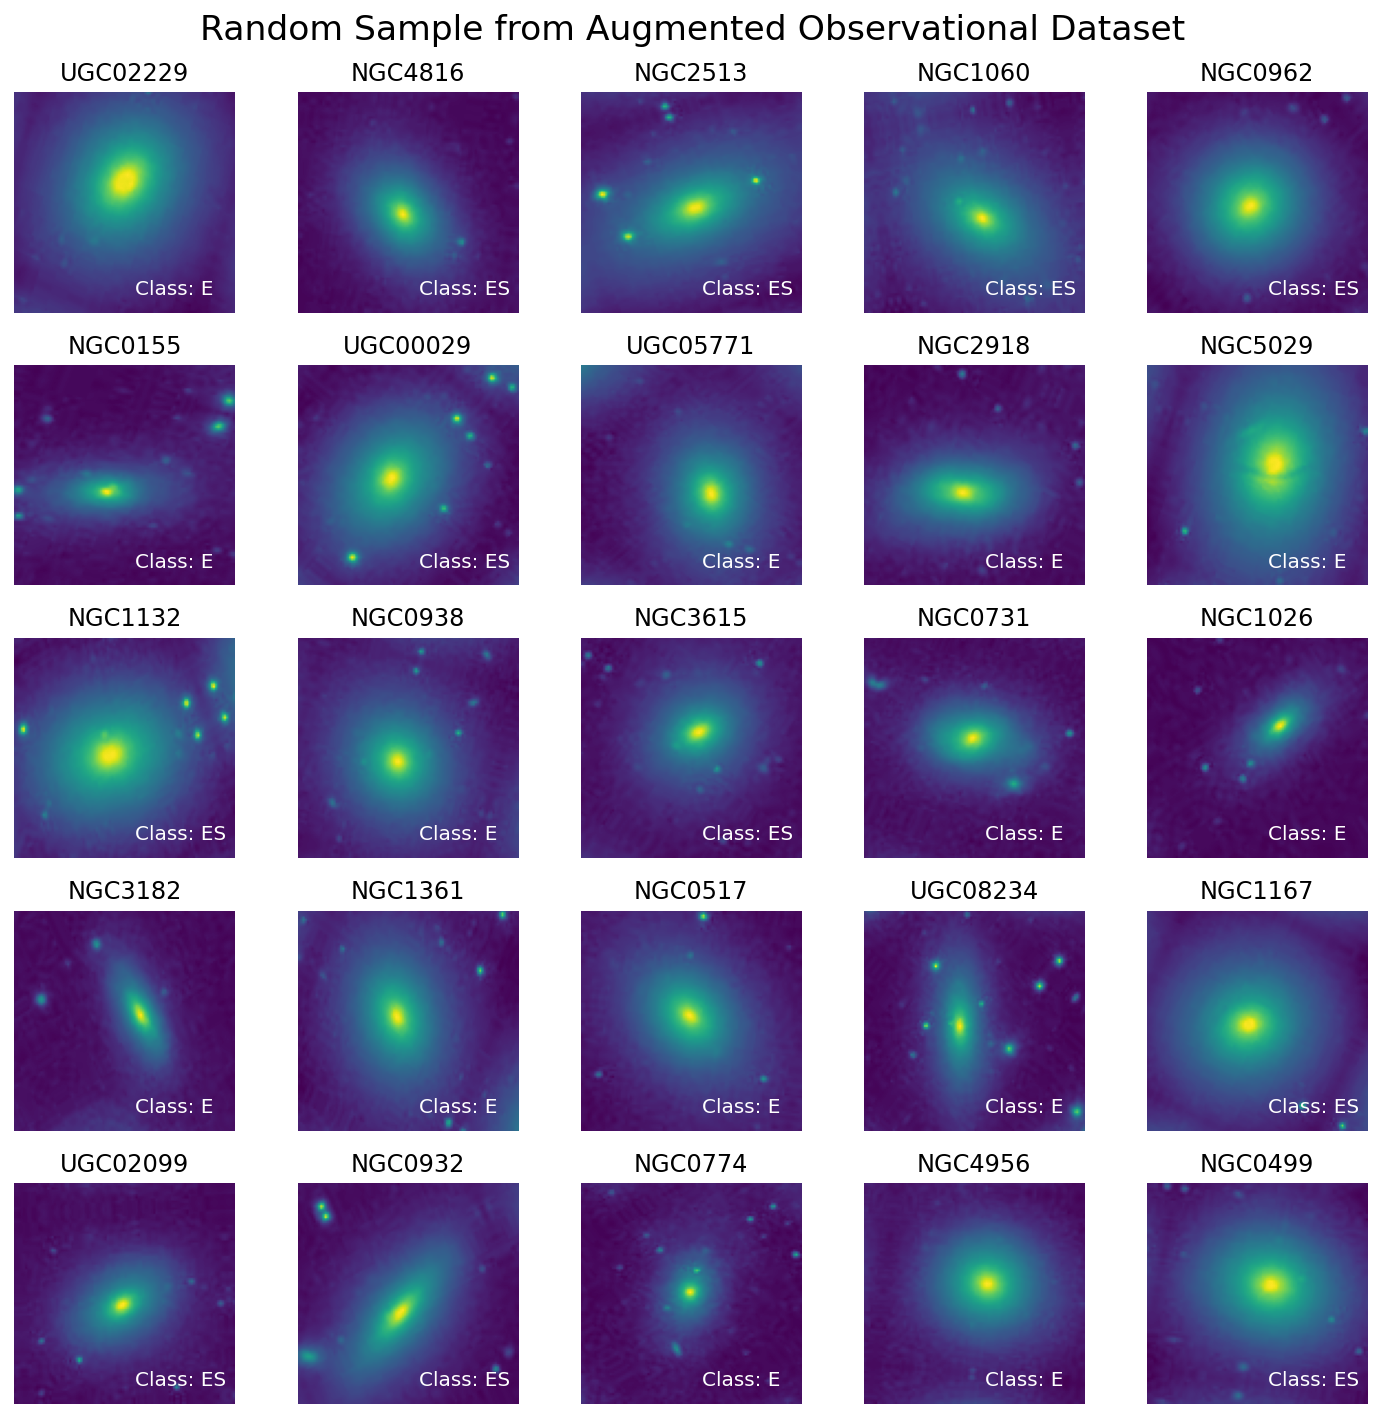

In [4]:
califa_datagen = create_datagen(x_califa)
plot_dataset(califa_datagen.flow(x_califa, y_califa, batch_size=25).next()[0], 
   metadata=metadata_califa, title="Random Sample from Augmented Observational Dataset")

## Simulation Dataset

(200, 100, 100)


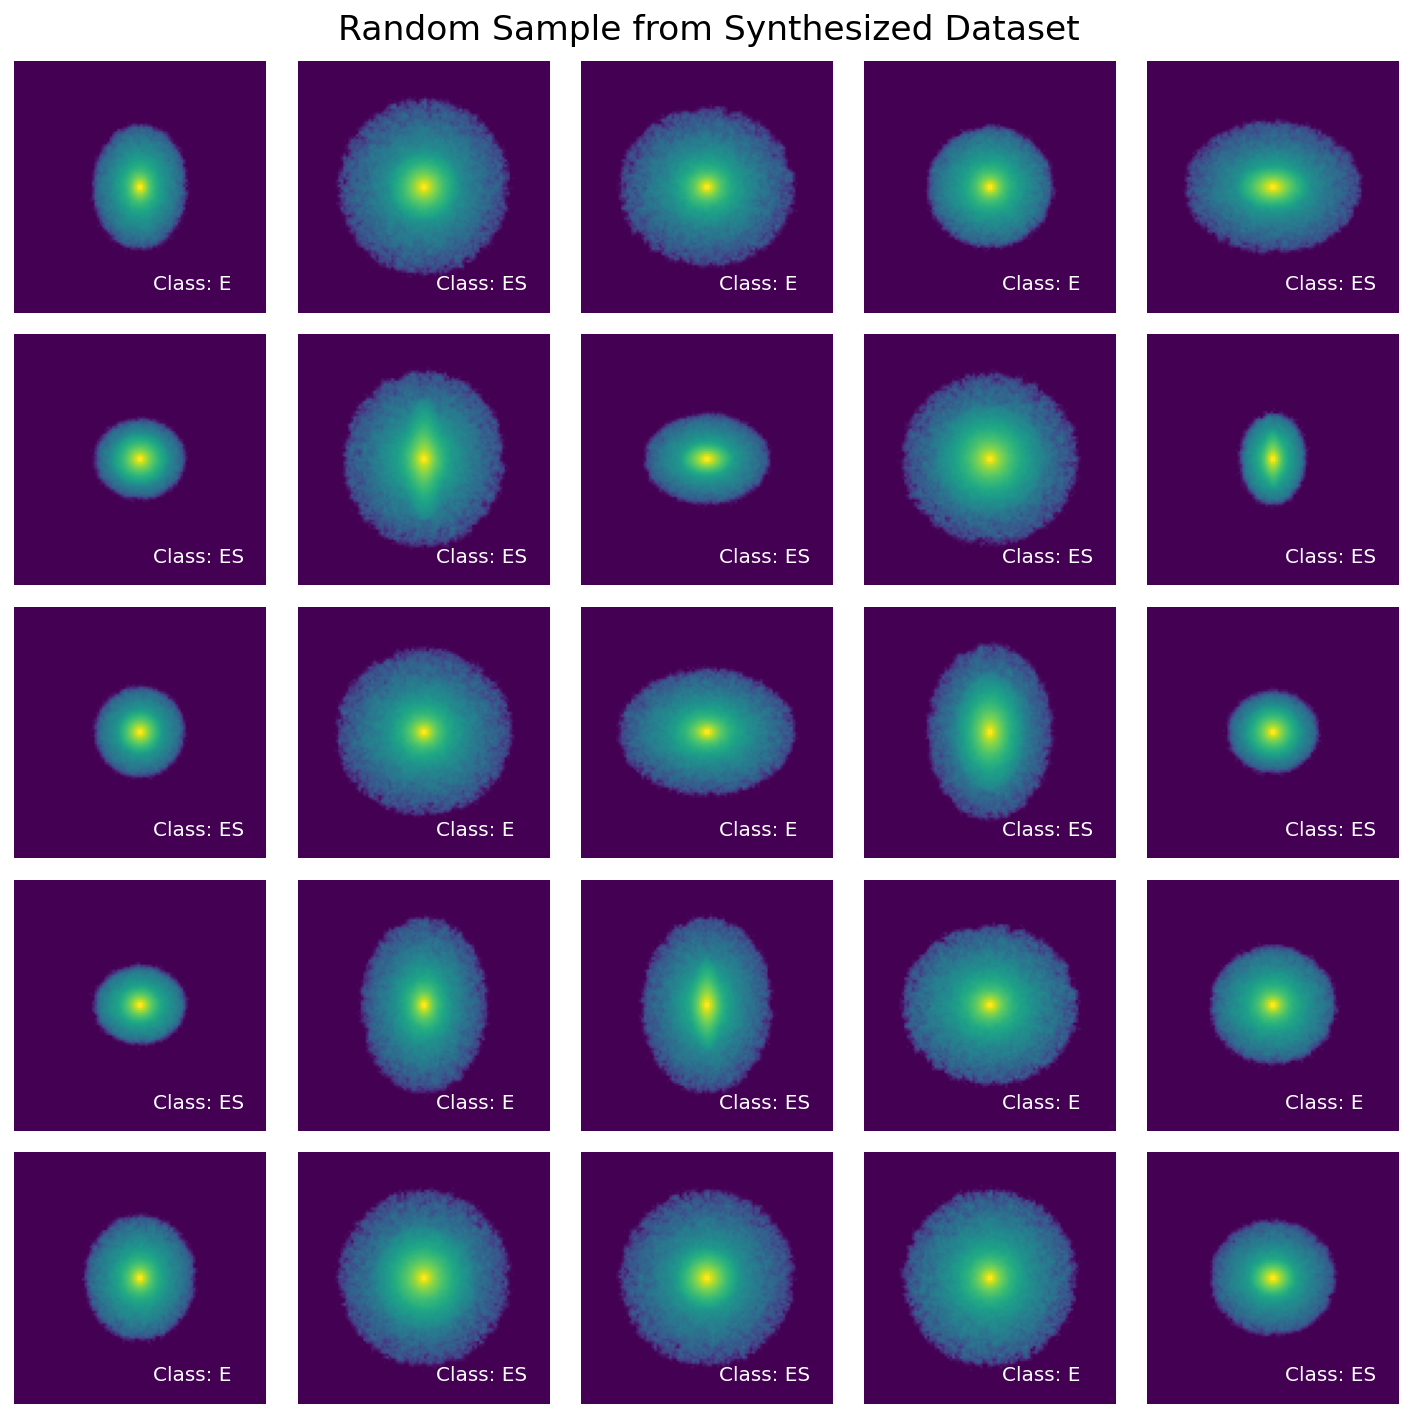

In [5]:
x_sim, y_sim, metadata_sim = load_hdf5_data("fd=0.3-0.7_hdf5", count=100)
plot_dataset(x_sim, metadata=metadata_sim, title="Random Sample from Synthesized Dataset")

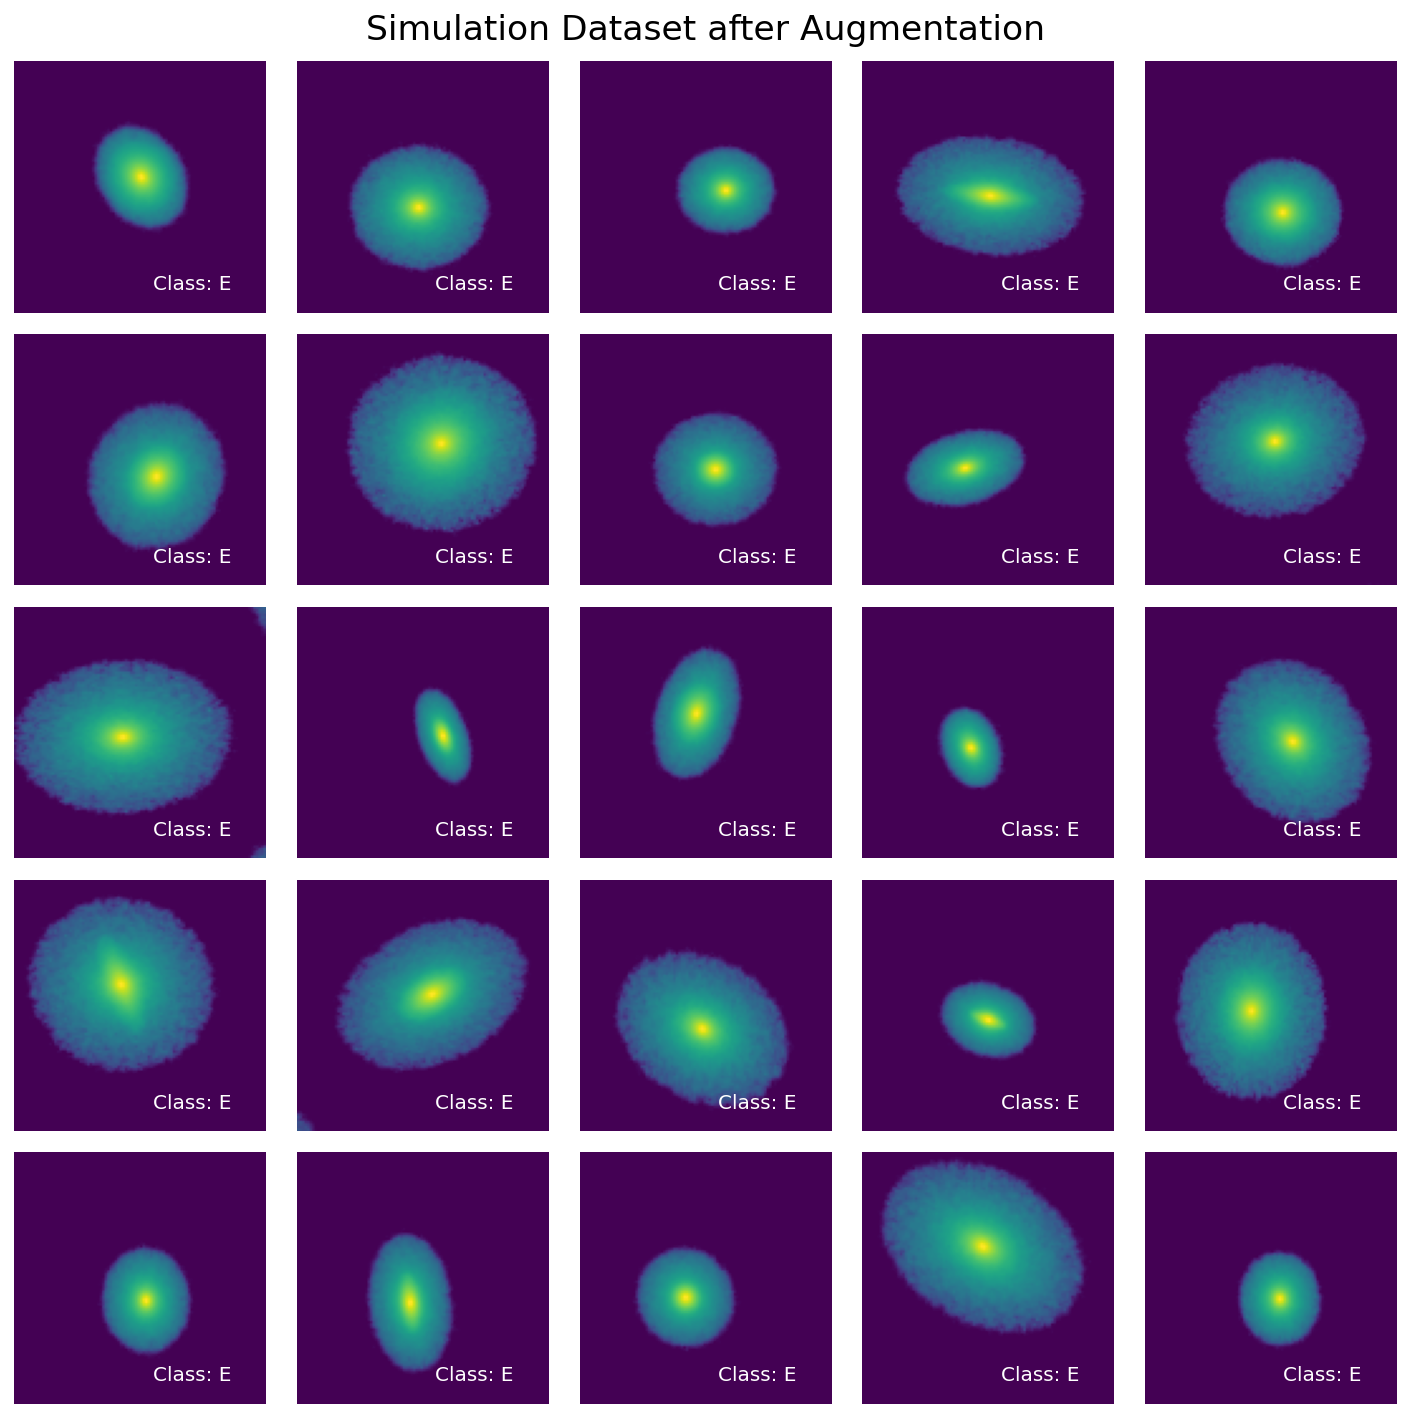

In [6]:
sim_datagen = create_datagen(np.expand_dims(x_sim, axis=3))
plot_dataset(sim_datagen.flow(np.expand_dims(x_sim, axis=3), np.expand_dims(y_sim, axis=1), batch_size=25).next()[0],
    metadata=metadata_sim, title="Simulation Dataset after Augmentation")

64


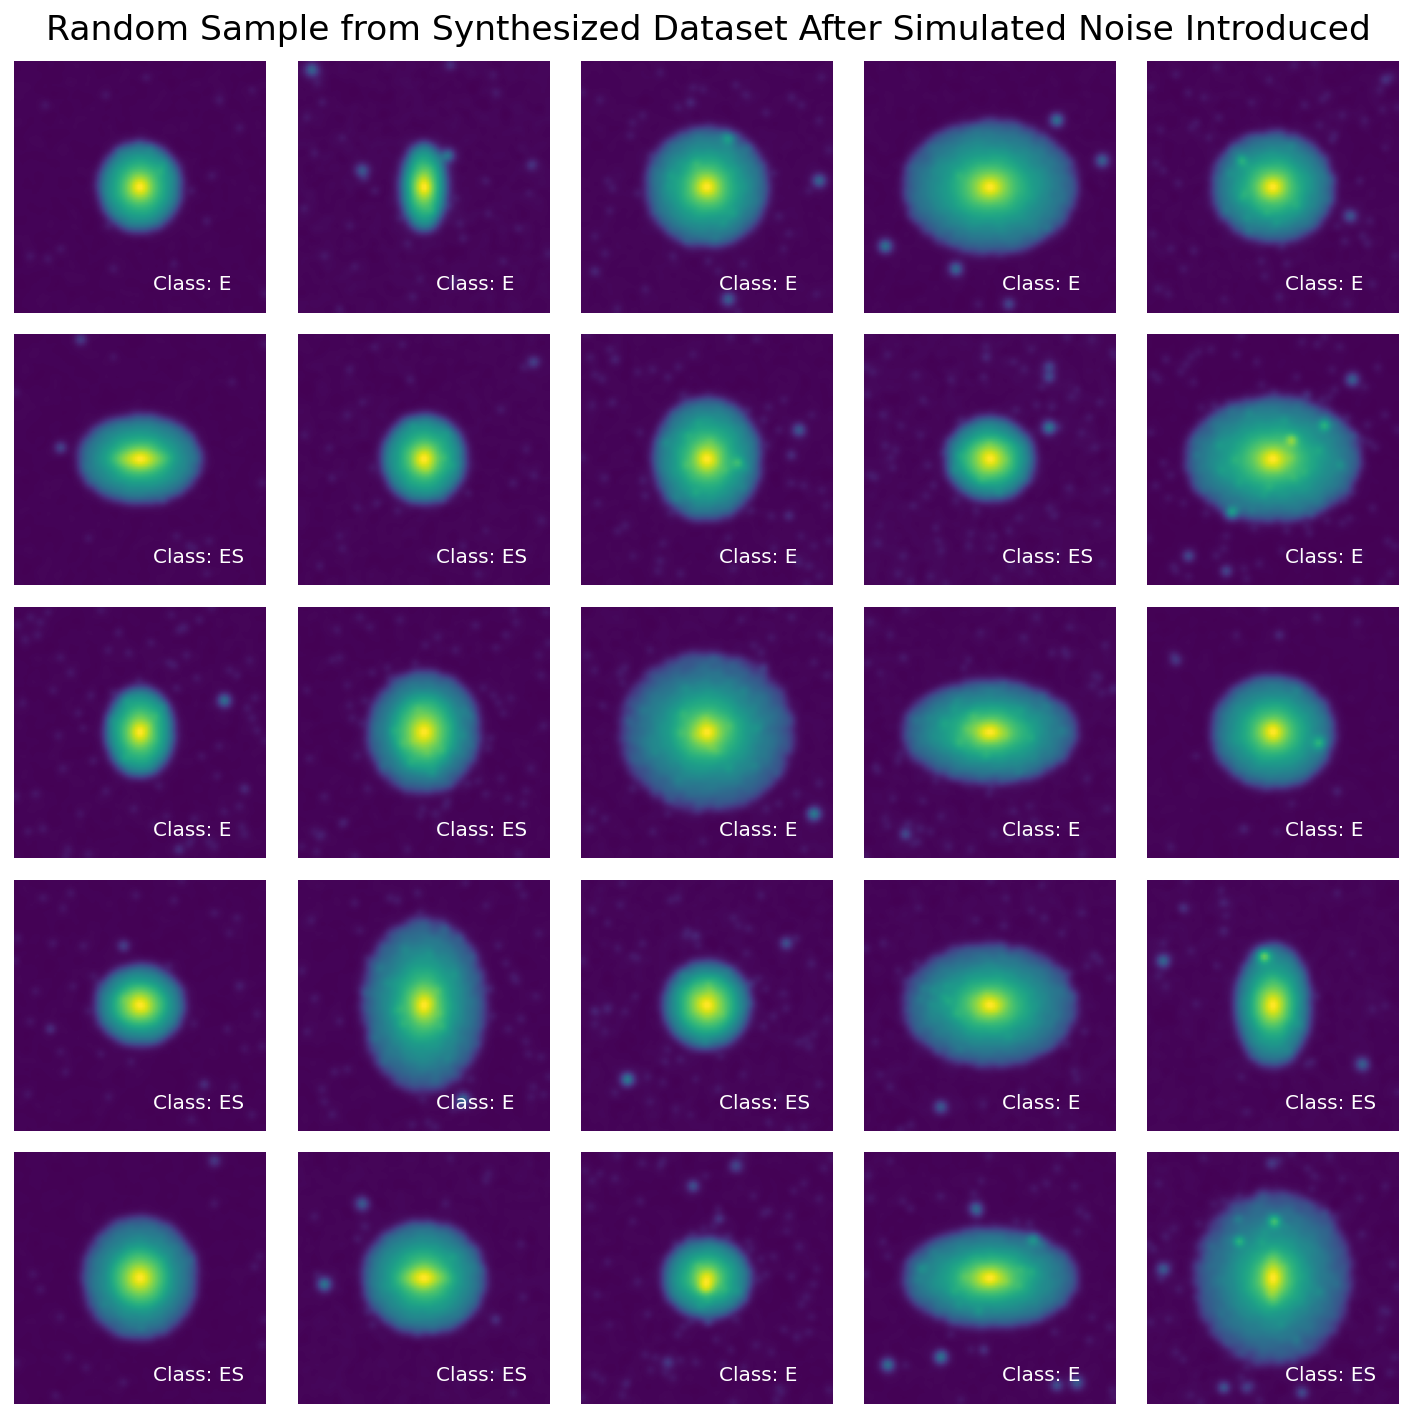

In [7]:
add_point_sources(x_sim)
add_background_galaxies(x_sim)
#apply_gaussian_PSF(x_dataset, 0.218598726) # General Gaussian PSF 0.218598726 0.573292215 1.3 20.84 8.85
#add_gaussian_noise(x_sim)
add_gaussian_noise(x_sim, noise_range=[0.01, 0.02])

#apply_moffat_PSF(x_dataset, 0.65049197562297747917932881055243, 1.3)
#apply_gaussian_PSF(x_sim, 0.218598726)
apply_moffat_PSF(x_sim, 4.148122, 4.765)
x_sim = np.expand_dims(x_sim, axis=3)
y_sim = np.expand_dims(y_sim, axis=1)
plot_dataset(x_sim, metadata=metadata_sim, title="Random Sample from Synthesized Dataset After Simulated Noise Introduced")

In [8]:
# x_sim, y_sim, metadata_sim = load_hdf5_data("fd=0.3-0.7_hdf5", count=None)
# x_sim_train, x_sim_val, y_sim_train, y_sim_val = train_test_split(x_sim, y_sim, shuffle=True, train_size=0.7, random_state=2021)
# x_sim_val, x_sim_test, y_sim_val, y_sim_test = train_test_split(x_sim_val, y_sim_val, shuffle=True, train_size=2/3, random_state=2021)
# plot_dataset(x_sim, metadata=metadata_sim, title="Random Sample from Simulation Dataset")

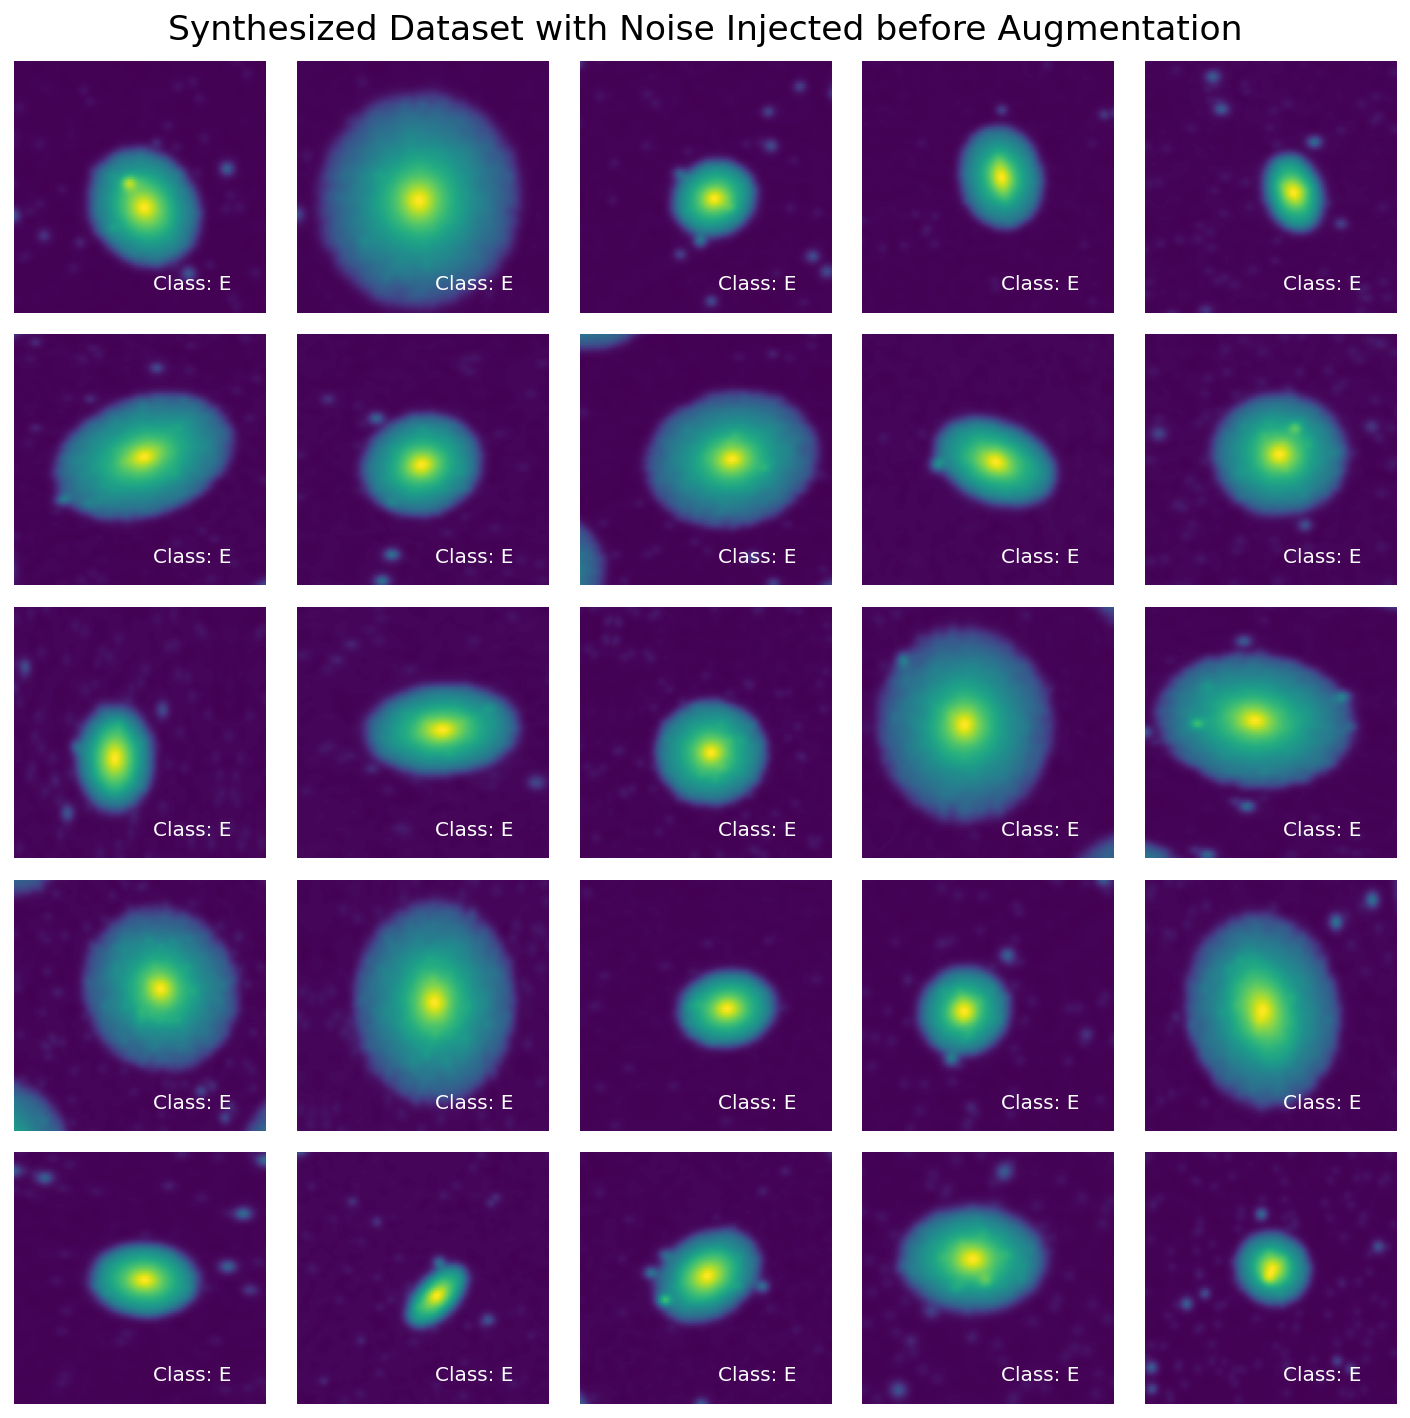

In [9]:
sim_noisy_datagen = create_datagen(x_sim)
plot_dataset(sim_noisy_datagen.flow(x_sim, y_sim, batch_size=25).next()[0],
    metadata=metadata_sim, title="Synthesized Dataset with Noise Injected before Augmentation")

# Models

## C2

### Trained on Simulation Data

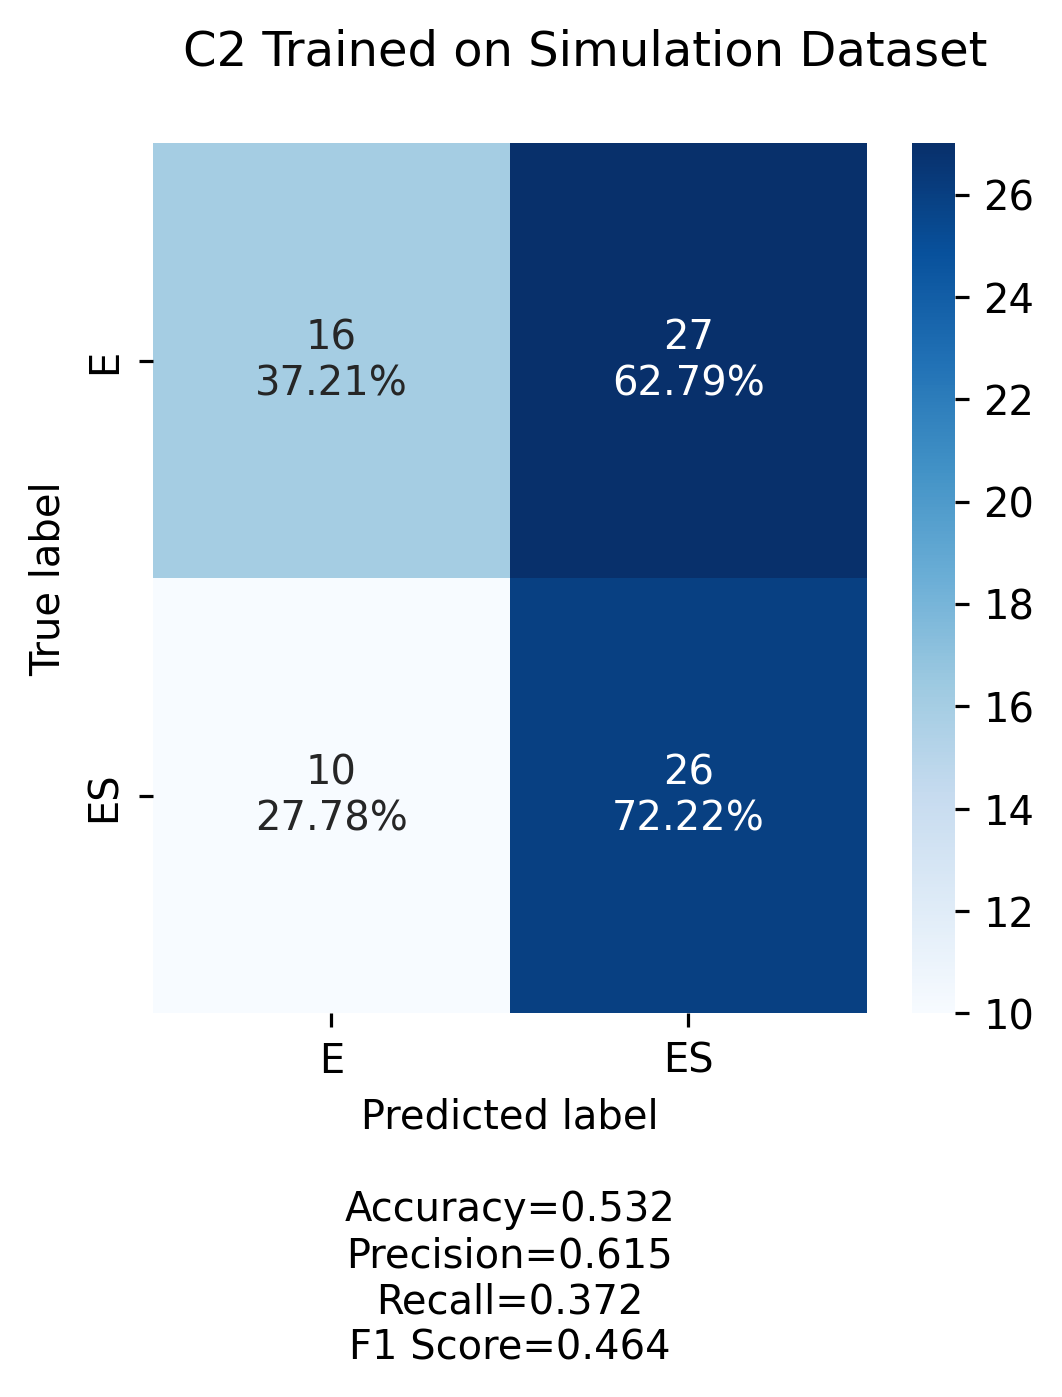

In [10]:
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 288

trained_model_path = f"./saved_models/result_models/final/c2/sim_with_gaussian_noise"
trained_model = tf.keras.models.load_model(trained_model_path, custom_objects={"LocalResponseNormalization": LocalResponseNormalization})

categories = ['E', 'ES']
make_confusion_matrix(confusion_matrix(y_califa, trained_model.predict(x_califa).argmax(axis=1)), categories=categories, cmap='Blues', title="C2 Trained on Simulation Dataset")

### Transferred using CALIFA Data

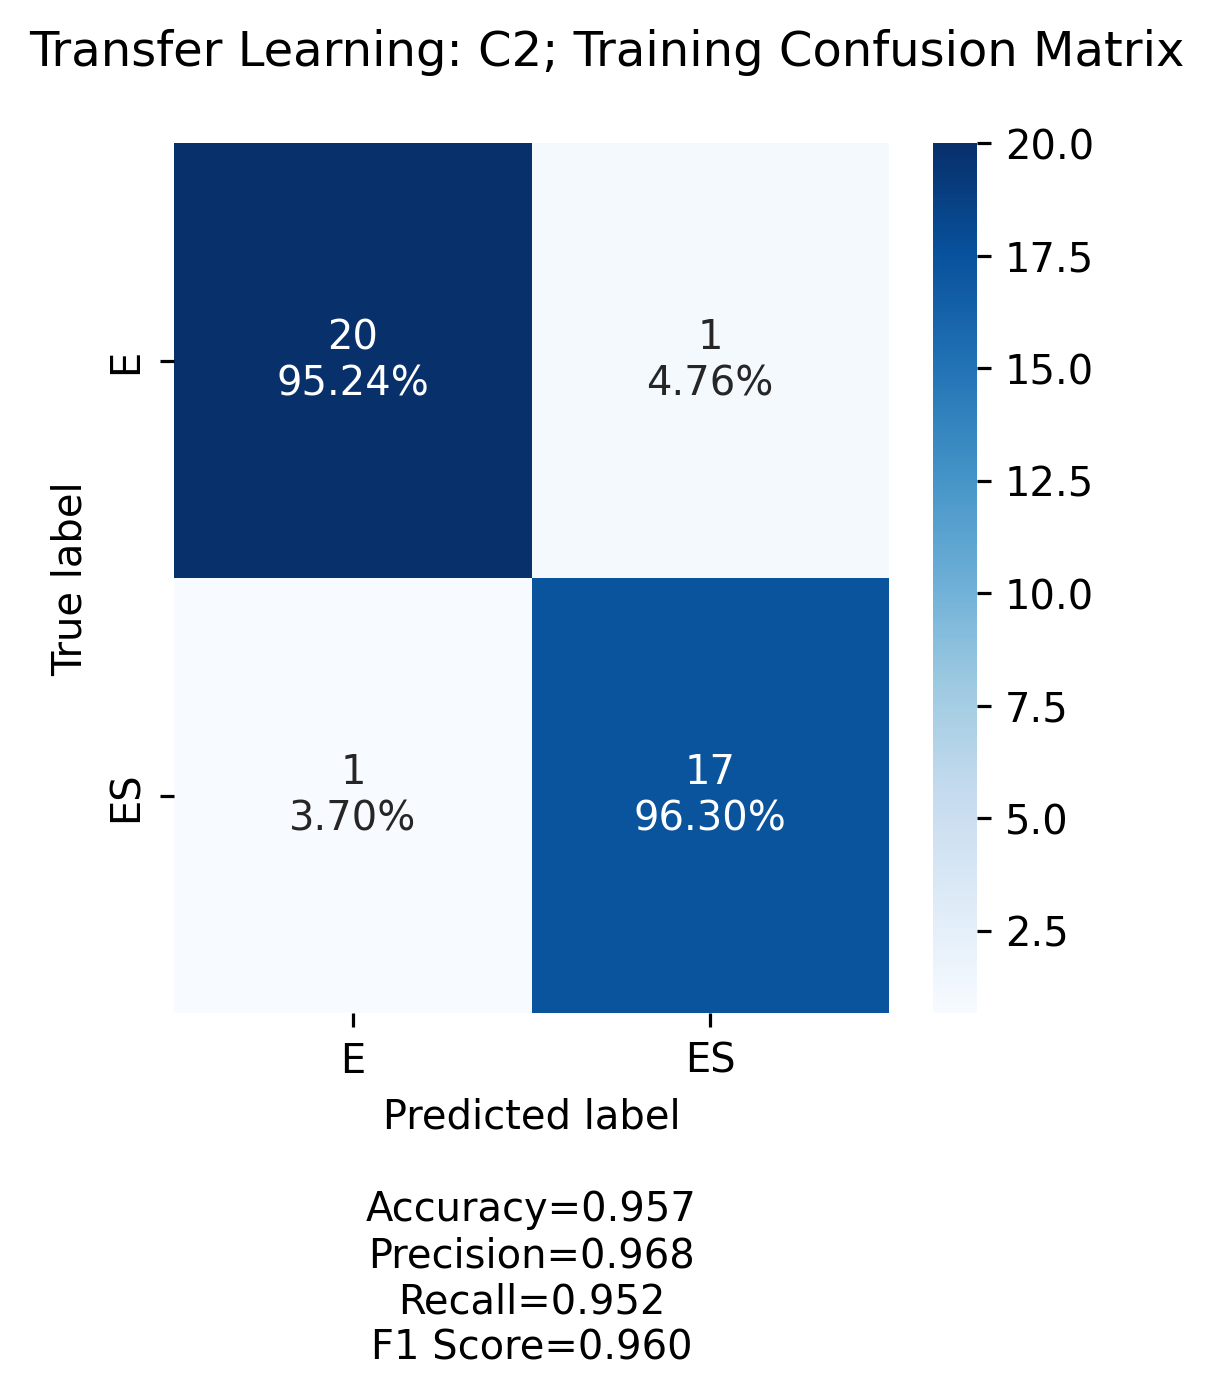

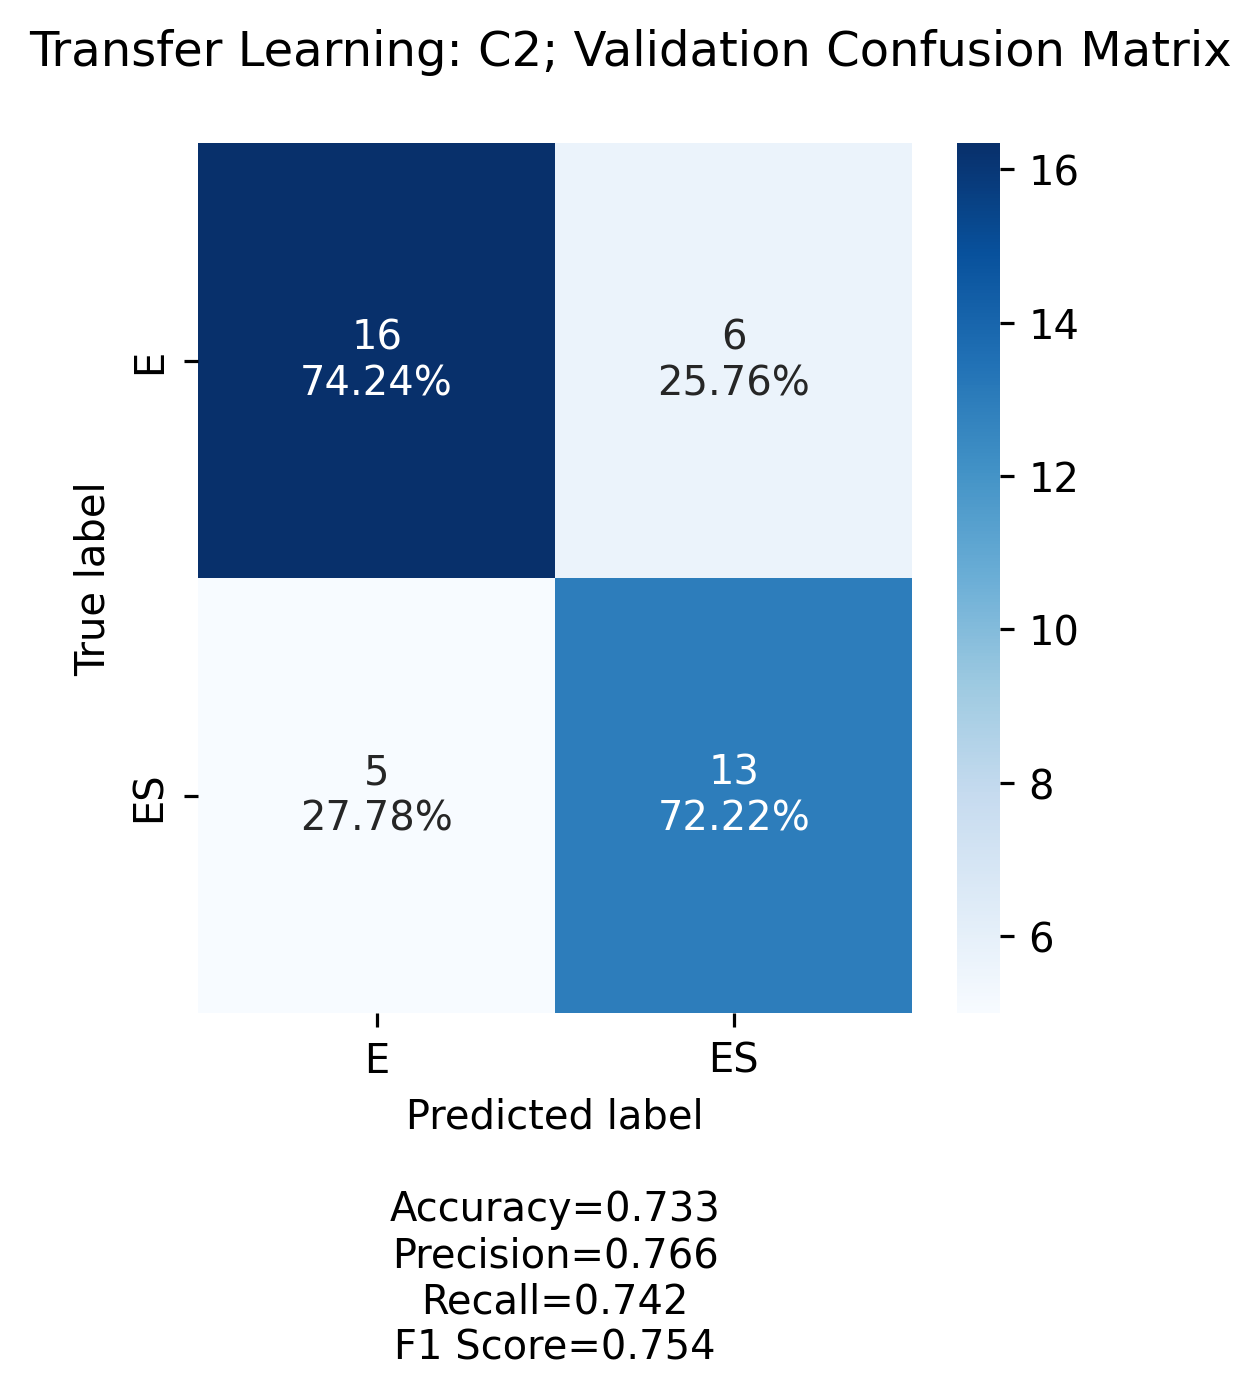

In [11]:
califa_transferred_model_path = f"./saved_models/result_models/final/c2/transfer_learning/tuned_model_val_split_0.5_mesh_100"
tuned_training_results = []
tuned_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_califa, y_califa)):
    tuned_model = tf.keras.models.load_model(f"{califa_transferred_model_path}_skf={i}.hdf5")
    #plot_model_results(tuned_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    tuned_training_results.append(get_results(tuned_model, x_califa[train_index], y_califa[train_index]))
    tuned_validation_results.append(get_results(tuned_model, x_califa[val_index], y_califa[val_index]))
plot_results(tuned_training_results, title="Transfer Learning: C2; Training Confusion Matrix")
plot_results(tuned_validation_results, title="Transfer Learning: C2; Validation Confusion Matrix")


### Trained Exclusively on Augmented CALIFA Data

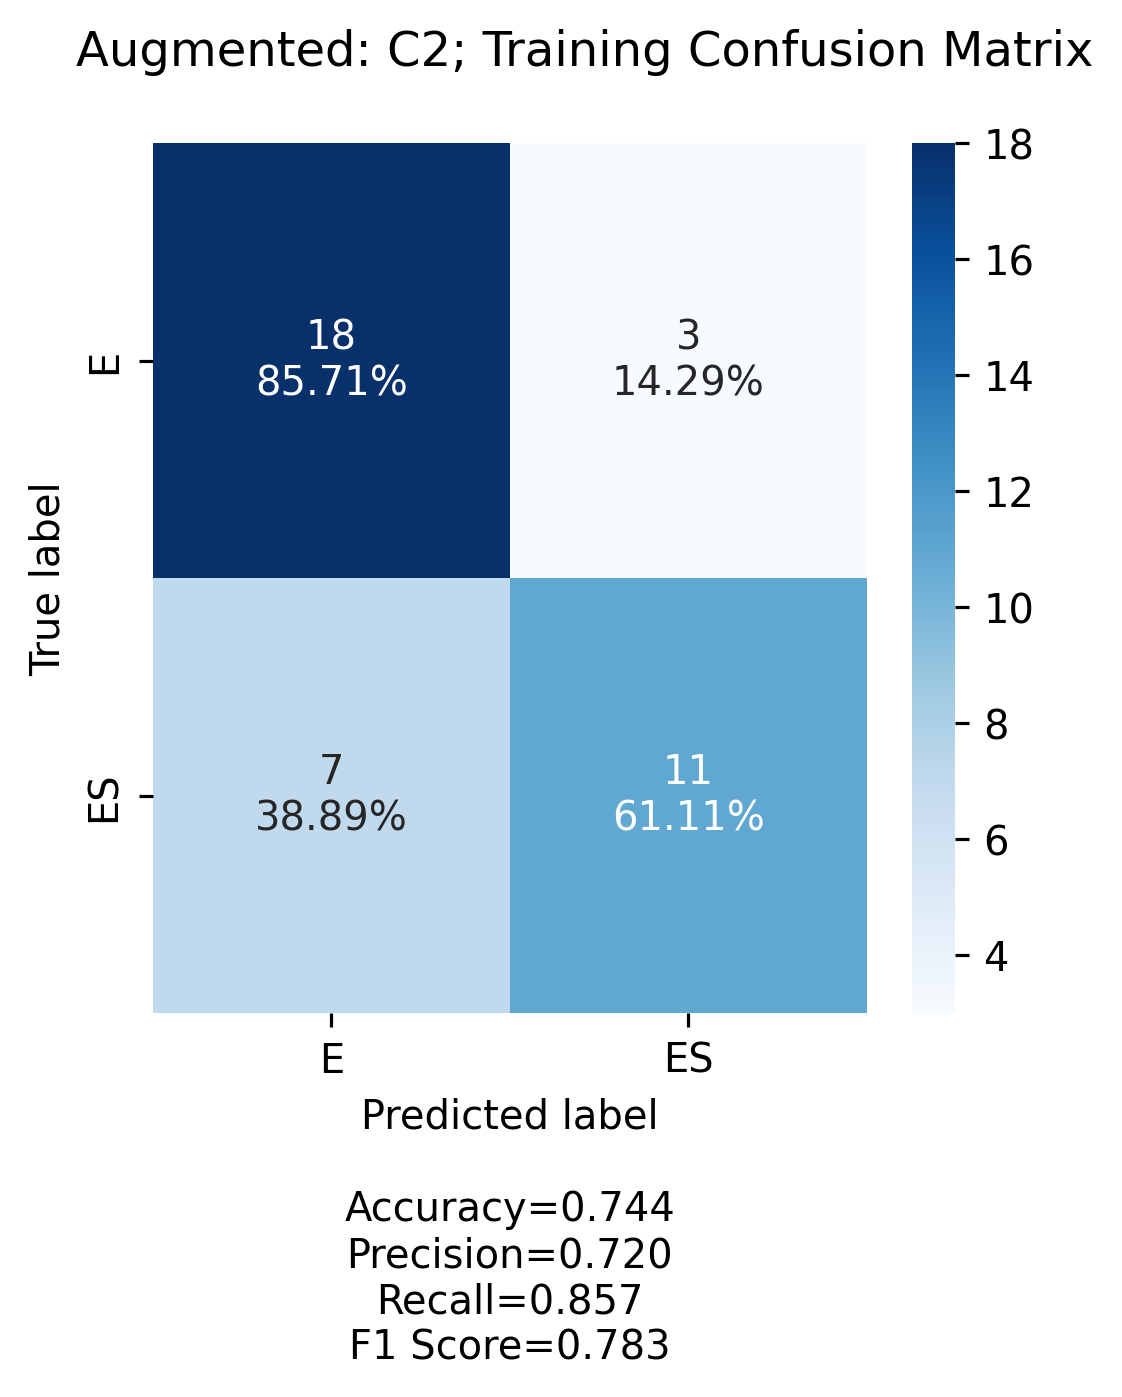

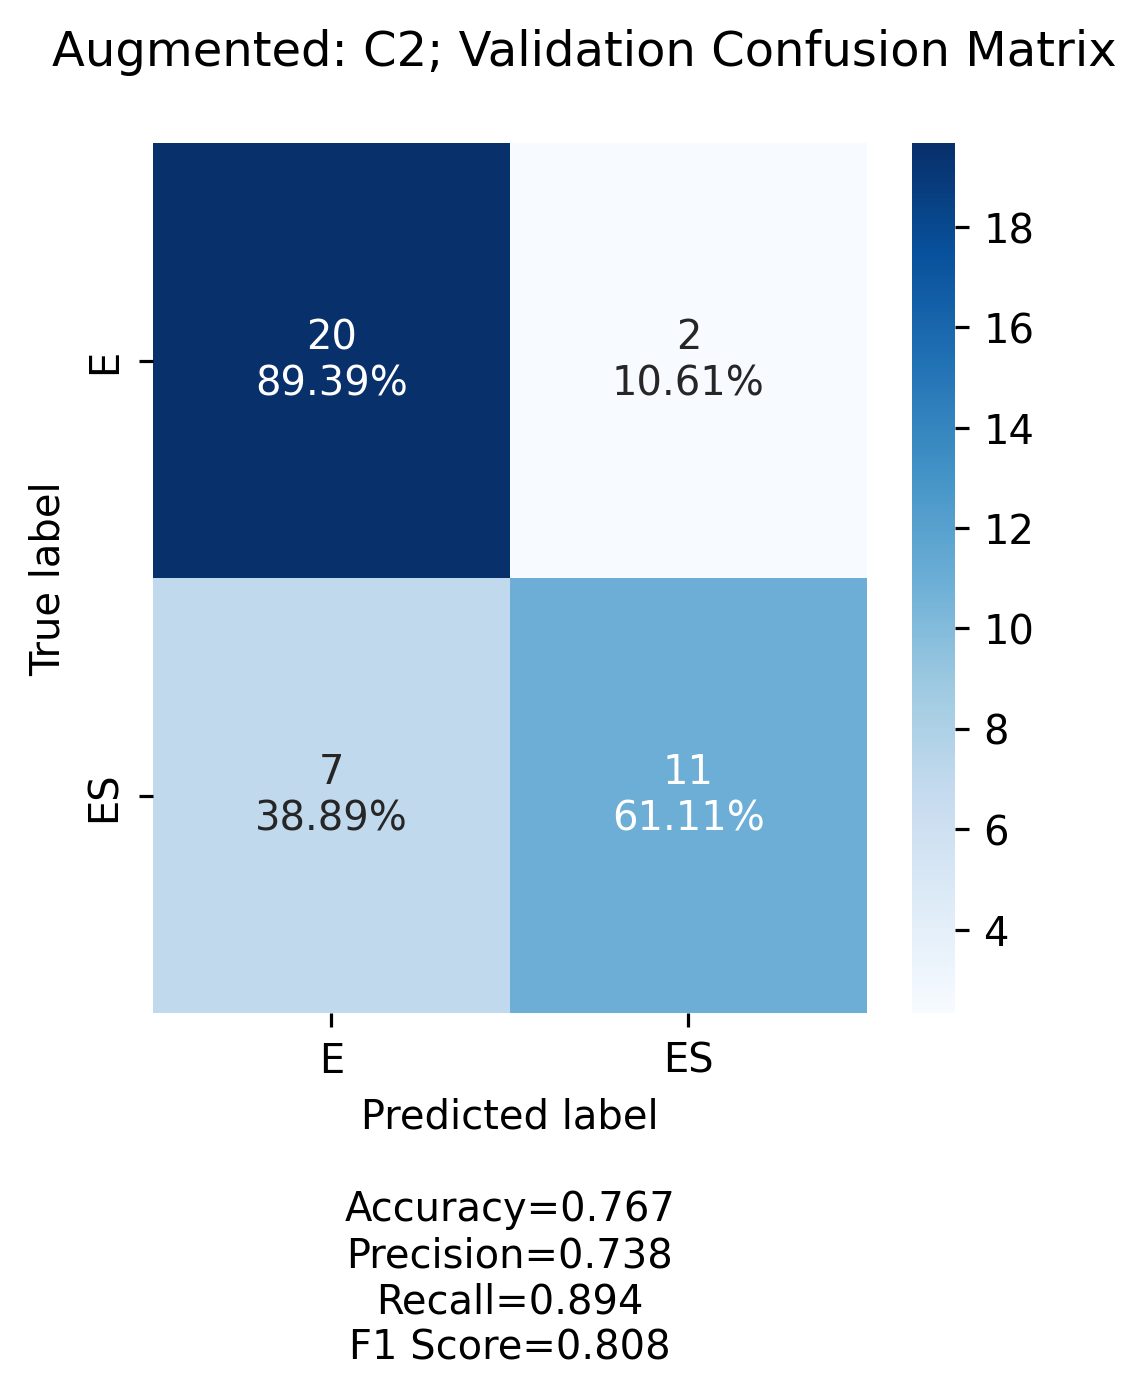

In [12]:
califa_augmented_model_path = f"./saved_models/result_models/final/c2/augmented/augmented"
training_results = []
validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_califa, y_califa)):
    model = tf.keras.models.load_model(f"{califa_augmented_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(tuned_model, x_dataset[train_index], y_dataset[train_index], x_dataset[val_index], y_dataset[val_index], x_dataset, y_dataset)
    training_results.append(get_results(model, x_califa[train_index], y_califa[train_index]))
    validation_results.append(get_results(model, x_califa[val_index], y_califa[val_index]))
plot_results(training_results, title="Augmented: C2; Training Confusion Matrix")
plot_results(validation_results, title="Augmented: C2; Validation Confusion Matrix")


## Gamornet

### Trained on Simulation Data

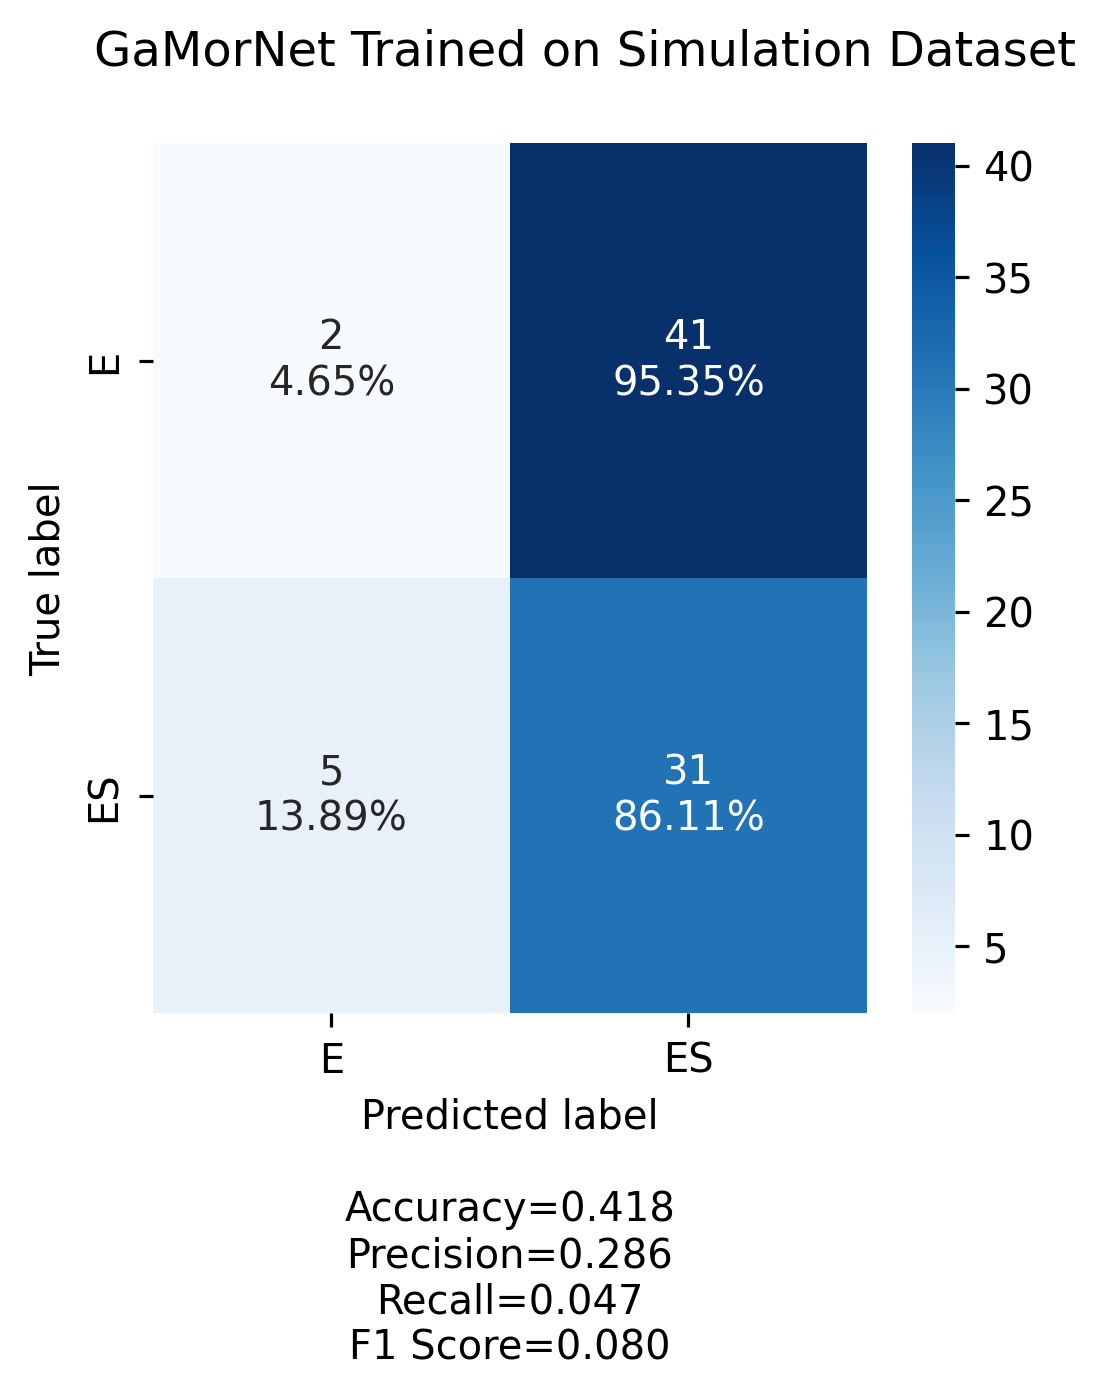

In [13]:
trained_model_path = f"./saved_models/result_models/final/gamornet/sim_with_gaussian_noise/trained_model_with_gaussian_noise.hdf5"
trained_model = tf.keras.models.load_model(trained_model_path, custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
make_confusion_matrix(confusion_matrix(y_califa, trained_model.predict(x_califa).argmax(axis=1)), categories=categories, cmap='Blues', title="GaMorNet Trained on Simulation Dataset")

### Transferred using CALIFA Data

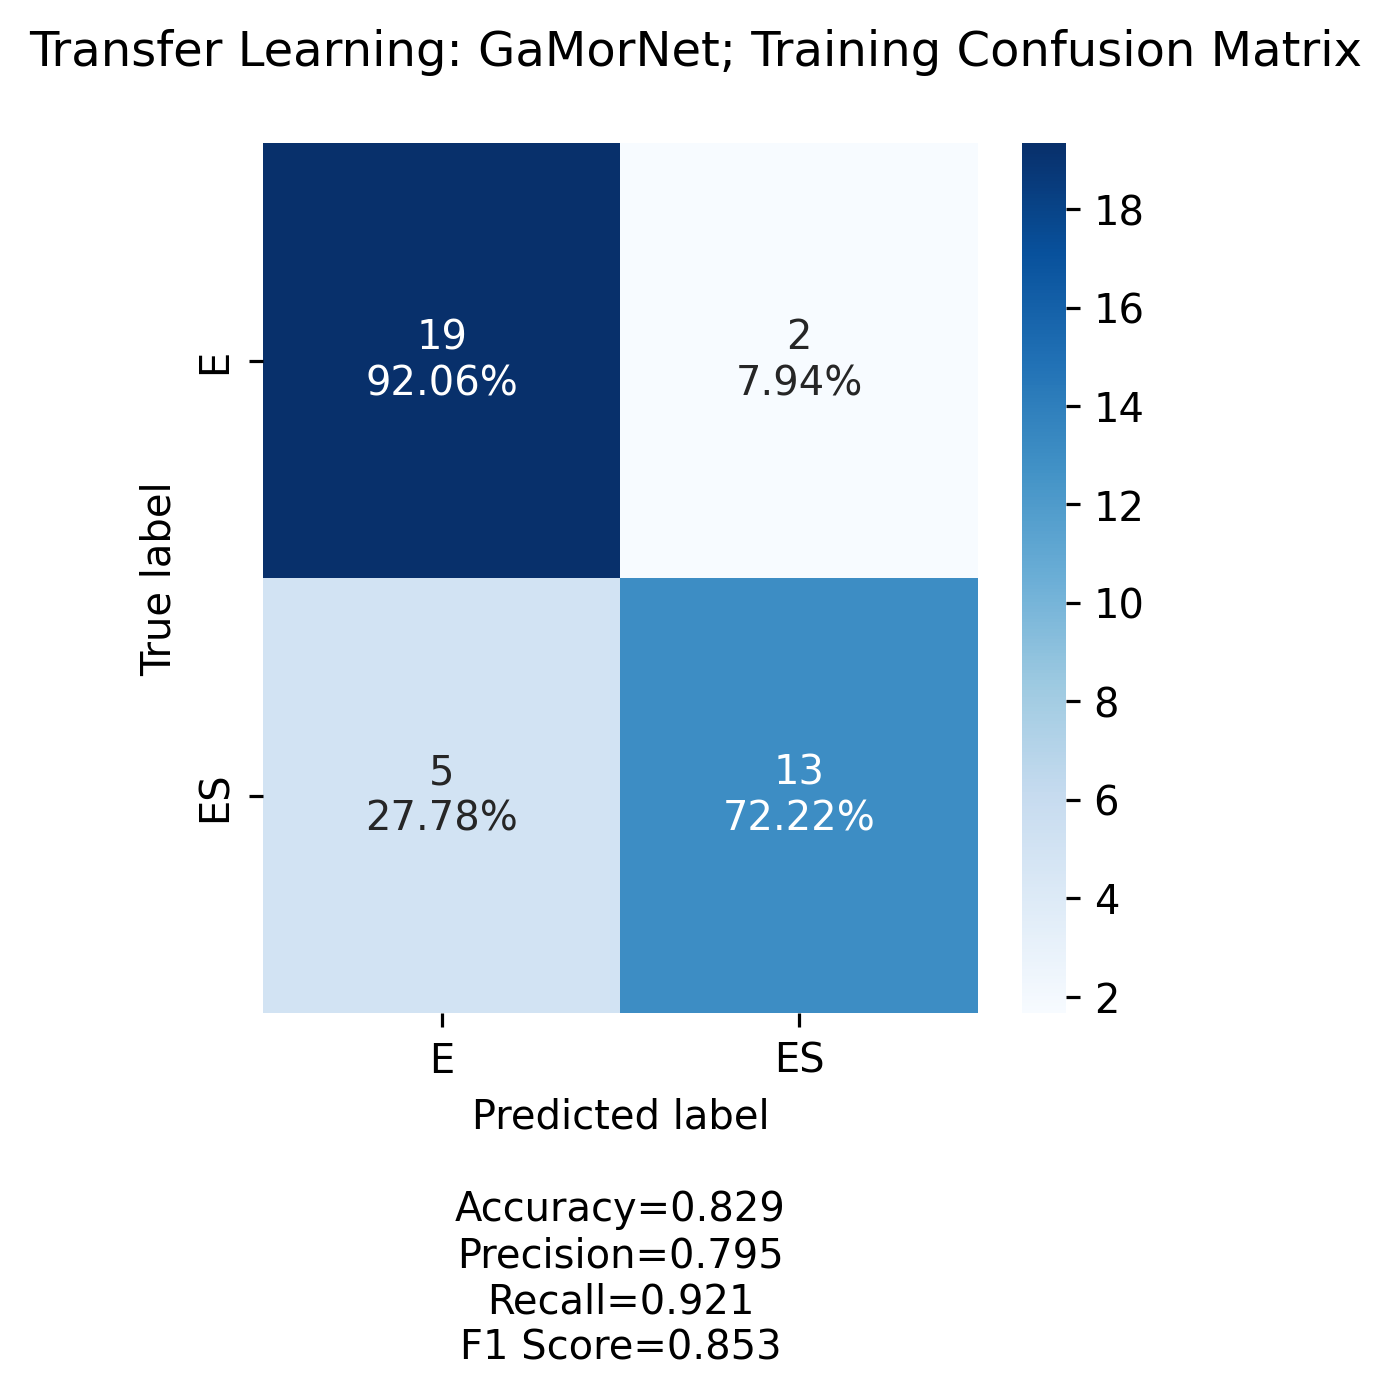

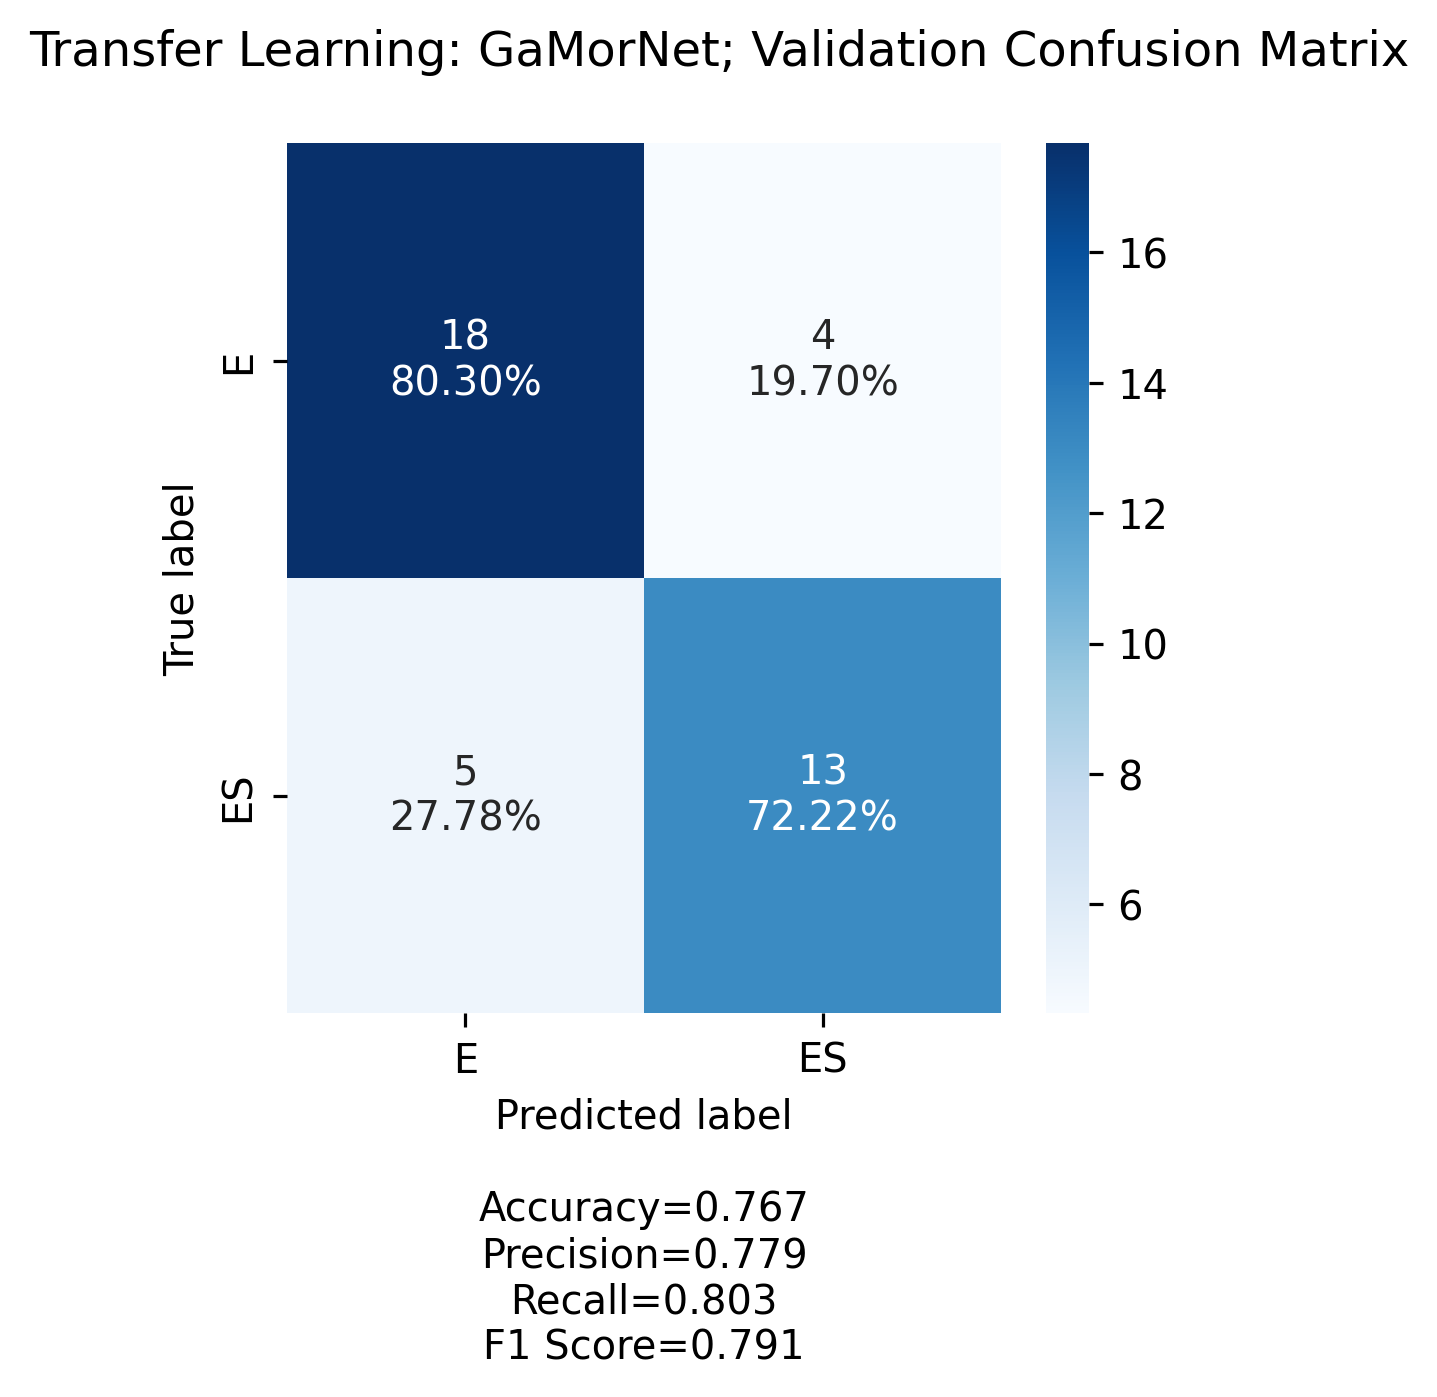

In [14]:
gamornet_transferred_model_path = f"./saved_models/result_models/finalgamornet/transfer_learning/tuned_model_with_reg_vs=0.5"
tuned_training_results = []
tuned_validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_califa, y_califa)):
    tuned_model = tf.keras.models.load_model(f"{gamornet_transferred_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(tuned_model, x_transfer[train_index], y_transfer[train_index], x_transfer[val_index], y_transfer[val_index], x_transfer, y_transfer)
    tuned_training_results.append(get_results(tuned_model, x_califa[train_index], y_califa[train_index]))
    tuned_validation_results.append(get_results(tuned_model, x_califa[val_index], y_califa[val_index]))
plot_results(tuned_training_results, title="Transfer Learning: GaMorNet; Training Confusion Matrix")
plot_results(tuned_validation_results, title="Transfer Learning: GaMorNet; Validation Confusion Matrix")


### Trained Exclusively on Augmented CALIFA Data

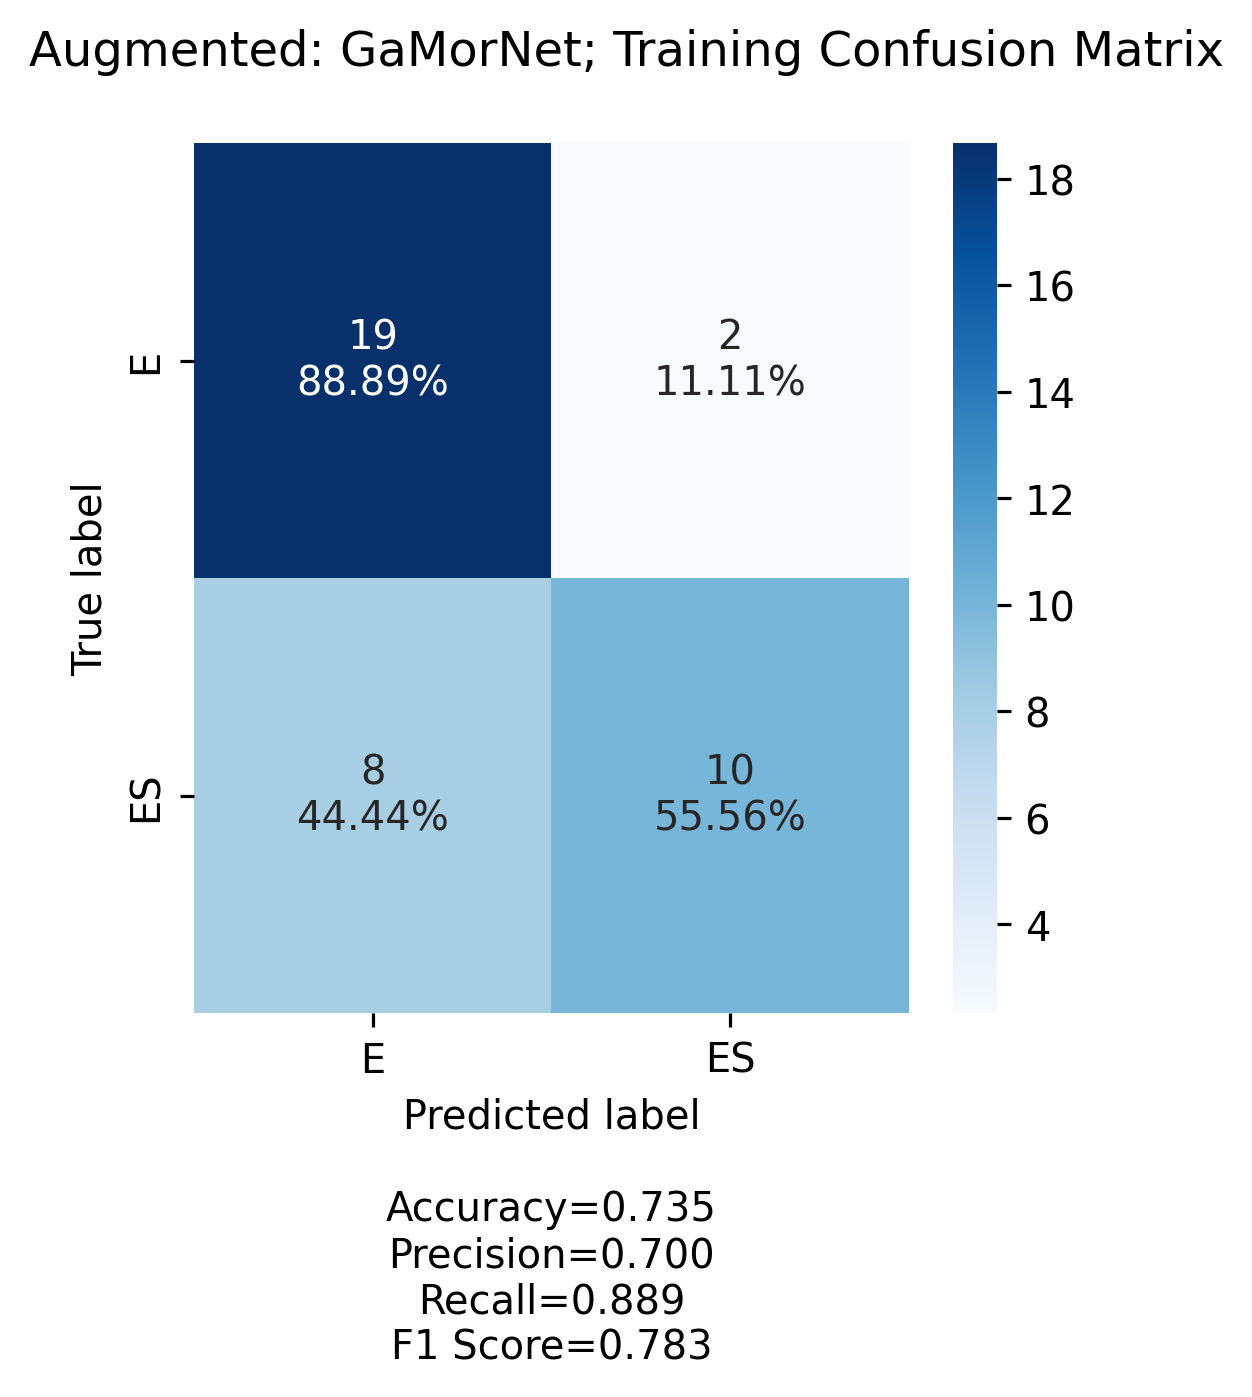

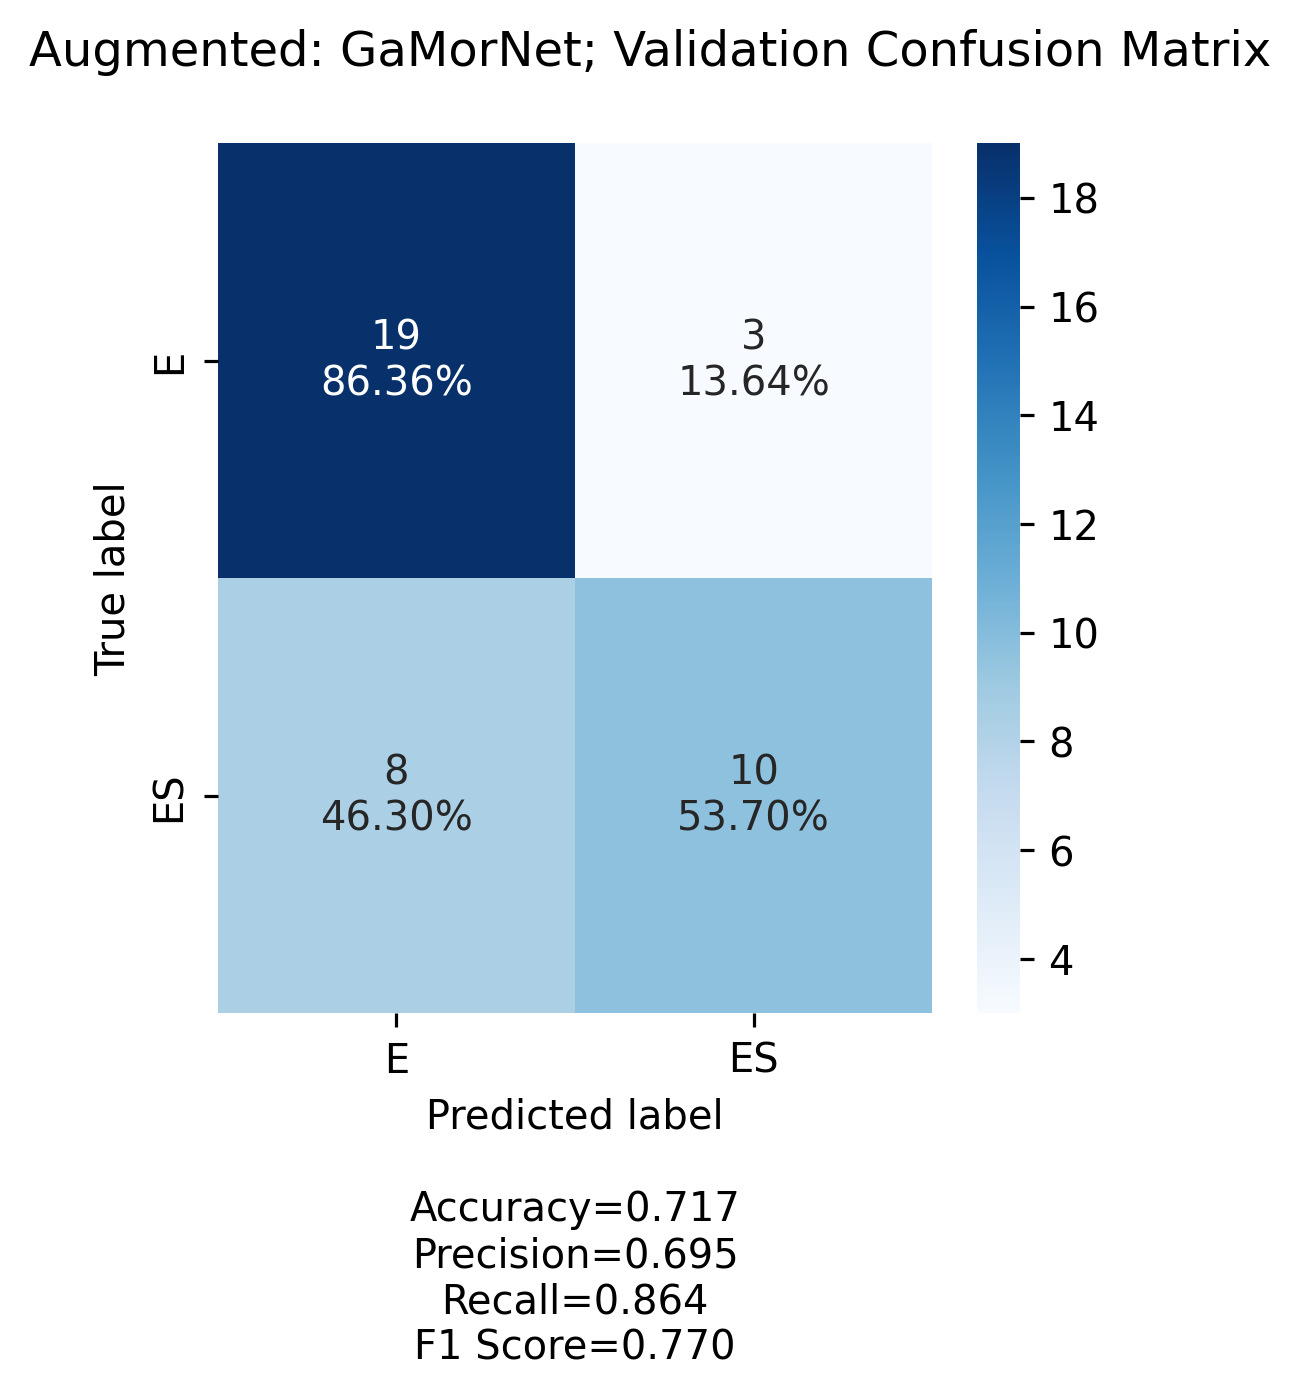

In [15]:
califa_augmented_model_path = f"./saved_models/result_models/final/gamornet/augmented/gamornet_augmented"
training_results = []
validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_califa, y_califa)):
    model = tf.keras.models.load_model(f"{califa_augmented_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(tuned_model, x_dataset[train_index], y_dataset[train_index], x_dataset[val_index], y_dataset[val_index], x_dataset, y_dataset)
    training_results.append(get_results(model, x_califa[train_index], y_califa[train_index]))
    validation_results.append(get_results(model, x_califa[val_index], y_califa[val_index]))
plot_results(training_results, title="Augmented: GaMorNet; Training Confusion Matrix")
plot_results(validation_results, title="Augmented: GaMorNet; Validation Confusion Matrix")


# Applications

## Class Distribution

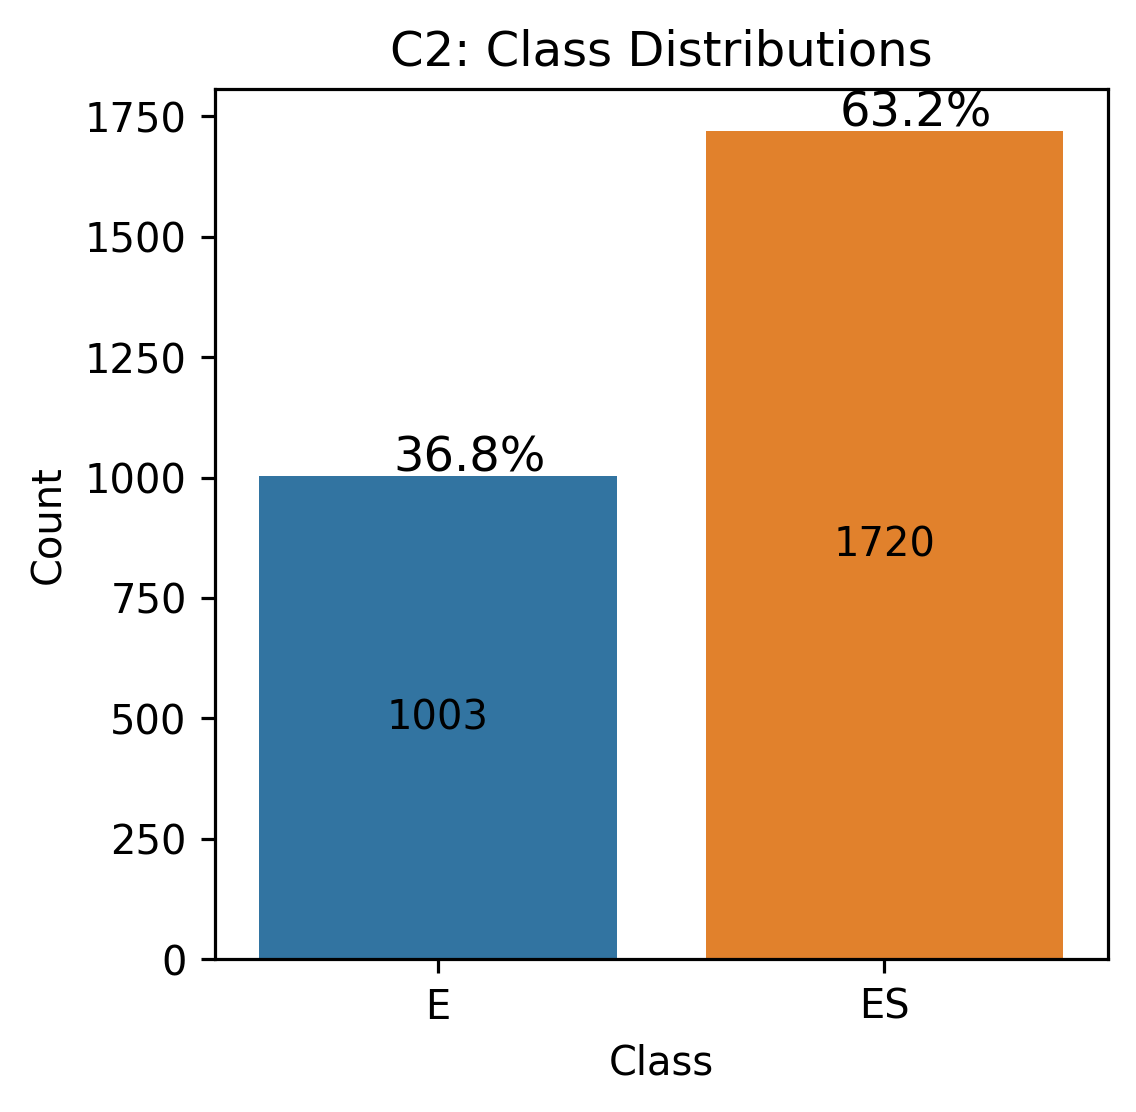

In [16]:
transferred_model_path = f"./saved_models/result_models/final/gamornet/transfer_learning/transferred_model_with_reg"
tuned_model_path = f"./saved_models/result_models/finalgamornet/transfer_learning/tuned_model_with_reg"
gamornet_transferred_model = tf.keras.models.load_model(f"{transferred_model_path}_complete.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})

c2_path = f"saved_models\\result_models\\final\\c2\\tuned_model_complete.hdf5"
califa_transferred_model = tf.keras.models.load_model(c2_path)

C2_NA10_predictions = califa_transferred_model.predict(x_nair).argmax(axis=1)

plot_class_distributions(C2_NA10_predictions, "C2")

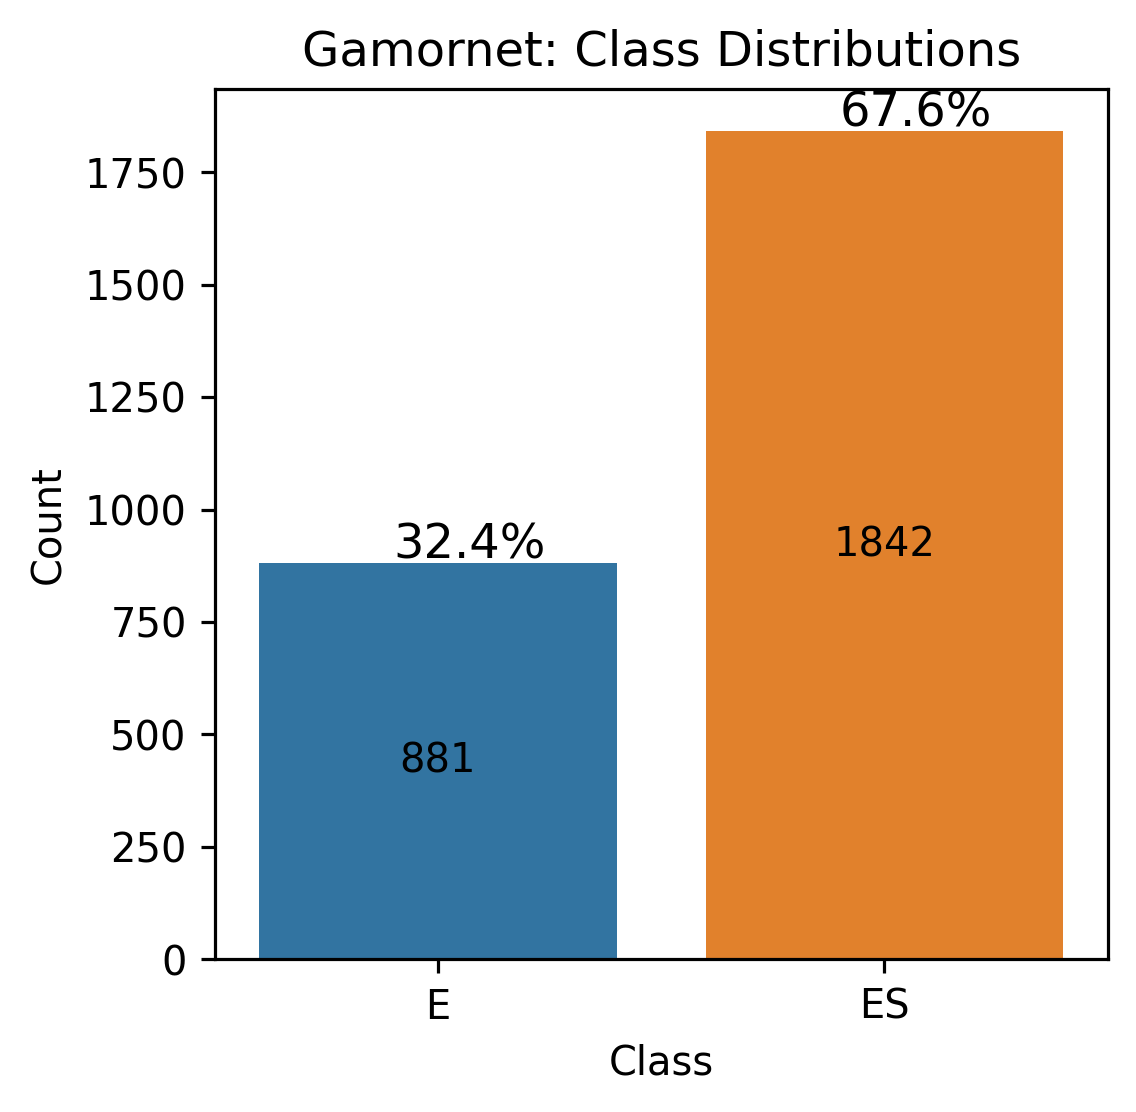

In [17]:
Gamornet_NA10_predictions = gamornet_transferred_model.predict(x_nair).argmax(axis=1)

plot_class_distributions(Gamornet_NA10_predictions, "Gamornet")


## Prediction Intersections

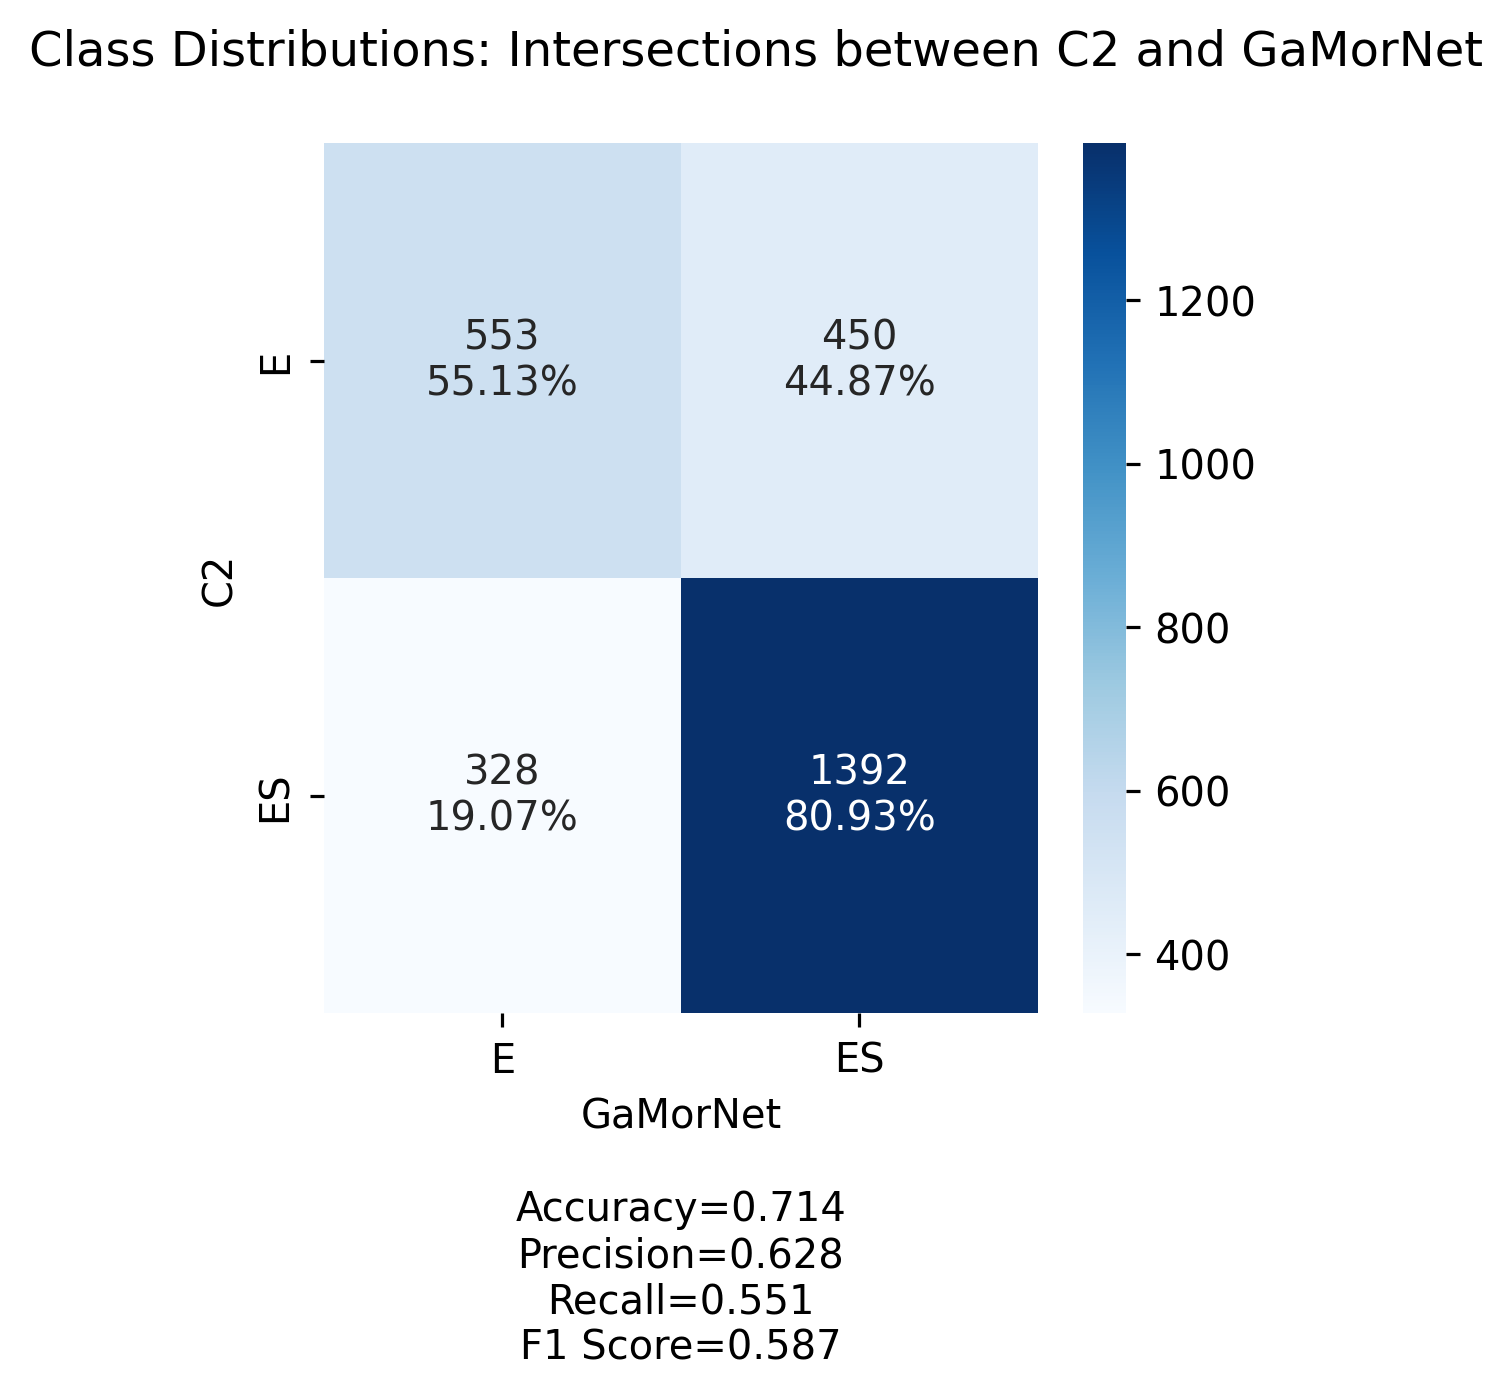

In [18]:
mpl.rcParams['figure.figsize'] = [4, 4]
mpl.rcParams['figure.dpi'] = 288
#labels = ['E & E', 'E & ES', 'E & ES', 'ES & ES']
#categories = ['C2', 'Gamornet']

labels = ['Gamornet & Califa', 'Gamornet & Califa', 'Gamornet & Califa', 'Gamornet & Califa']
categories = ['E', 'ES']

make_confusion_matrix(confusion_matrix(C2_NA10_predictions, Gamornet_NA10_predictions), true_pred_labels=['C2', 'GaMorNet'], categories=categories, cmap='Blues', title="Class Distributions: Intersections between C2 and GaMorNet")

In [19]:
c2_NA10_E = C2_NA10_predictions == Classes.E
c2_NA10_ES = C2_NA10_predictions == Classes.ES
gamornet_NA10_E = Gamornet_NA10_predictions == Classes.E
gamornet_NA10_ES = Gamornet_NA10_predictions == Classes.ES

c2_E_gam_E = np.count_nonzero(np.multiply(c2_NA10_E, gamornet_NA10_E))
c2_E_gam_ES = np.count_nonzero(np.multiply(c2_NA10_E, gamornet_NA10_ES))
c2_ES_gam_E = np.count_nonzero(np.multiply(c2_NA10_ES, gamornet_NA10_E))
c2_ES_gam_ES = np.count_nonzero(np.multiply(c2_NA10_ES, gamornet_NA10_ES))

print(c2_E_gam_E)
print(c2_E_gam_ES)
print(c2_ES_gam_E)
print(c2_ES_gam_ES)

553
450
328
1392


# Interesting Properties

In [20]:
def plot_phys_prop_hists(metadata, pred, properties, model_name):

    colours = ["blue", "skyblue"]
    preds = [metadata.iloc[pred == Classes.E], metadata.iloc[pred == Classes.ES]]
    classes = ["E", "ES"]
    fig, axs = plt.subplots(2, 4)#, figsize=(100, 100))
    fig.suptitle(f"{model_name}: Predicted E and ES Physical Properties", fontsize='xx-large')
    short_properties = {
        "Age in Gyr": "Age", 
        "Mass in Log units": "Mass",
        "Axis Ratio (b/a)": "Axis Ratio",
        "Luminosity in g' band in solar unit": "Luminosity",
        "Rp50 from SDSS in kiloparsec": "Rp50",
        "Rp90 from SDSS in kiloparsec": "Rp90",
        "Group Mass in Log units": "Group Mass",
        "Single component Sersic index in g band": "SCS Index"
    }

    for property, ax in zip(properties, axs.flatten()):
        legend = []
        for pred, colour, cls in zip(preds, colours, classes):
            ax.yaxis.set_major_formatter(PercentFormatter(1))
            na_begone = pred[property].dropna()

            w = (np.ones(len(na_begone))/len(na_begone))
            na_begone.hist(bins=6, legend=True, ax=ax, color = colour, alpha=0.75, weights = w)
            short_property = short_properties[property]
            legend.append(f"{cls}: {short_property}")
        ax.legend(legend, fontsize='large', bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
    plt.tight_layout()

In [21]:
mpl.rcParams['figure.figsize'] = [10, 10]
mpl.rcParams['figure.dpi'] = 144

x_nair, y_nair, metadata_nair = load_hdf5_data(name="nair_abraham_2010_hdf5")
x_nair = np.expand_dims(x_nair, axis=3)
y_nair = np.expand_dims(y_nair, axis=1)

# Clean metadata
metadata_nair = metadata_nair.replace(999999.0, np.nan)
metadata_nair = metadata_nair.replace(0.0, np.nan)

metadata_nair['Mass'].where(metadata_nair['Mass'] > 0, np.nan, inplace=True)
metadata_nair['Mass_group'].where(metadata_nair['Mass_group'] > 0, np.nan, inplace=True)

display(metadata_nair['Mass'].describe())
# # Add units
metadata_nair.rename(columns={
    "Age": "Age in Gyr",
    "z": "Spectroscopic redshift", 
    "Mass": "Mass in Log units",
    "zconf": "Spectroscopic redshift confidence level",
    "g": "g' apparent magnitude",
    "r": "r' apparent magnitude",
    "M_g": "g'-band absolute magnitude", 
    "L_g": "Luminosity in g' band in solar unit",
    "Rp_g": "Petrosian radius in kiloparsec",
    "Rp50_g": "Rp50 from SDSS in kiloparsec",
    "Rp90_g": "Rp90 from SDSS in kiloparsec",
    "bOverA": "Axis Ratio (b/a)",
    "Mass_group": "Group Mass in Log units",
    "n_g": "Single component Sersic index in g band"
}, inplace=True)

#properties_to_investigate = metadata_nair.columns.drop(labels=["RA", "DEC", "JID", "NYU-DR4_Object_Tag", "Bar", "Lens", "Ring", "Ring_flag", "groupid", "tails", "class", "spID"])
print(metadata_nair.columns)
#properties_to_investigate = ['Age', 'L_g', 'Mass', 'bOverA', 'Mass_group', 'Rp50_g', 'Rp90_g', 'n_g']
properties_to_investigate = ['Age in Gyr', "Luminosity in g' band in solar unit", 'Mass in Log units', 'Axis Ratio (b/a)', "Group Mass in Log units", 
'Rp50 from SDSS in kiloparsec', 'Rp90 from SDSS in kiloparsec', 'Single component Sersic index in g band']


E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'NYU-DR4_Object_Tag'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'g-r'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


(2723, 100, 100)


count    2675.000000
mean       10.995936
std         0.379283
min         8.868000
25%        10.787500
50%        11.045000
75%        11.264000
max        11.783000
Name: Mass, dtype: float64

Index(['AGN_Kauffmann', 'AGN_Kewley', 'Age in Gyr', 'Area', 'Bar', 'DEC',
       'JID', 'Luminosity in g' band in solar unit', 'Lens', 'Lum_group',
       'g'-band absolute magnitude', 'M_over_L', 'Mass in Log units',
       'Group Mass in Log units', 'NYU-DR4_Object_Tag', 'Ngroup', 'Pair_flag',
       'Pairs', 'R50_n', 'R90_n', 'RA', 'RC3', 'Ring', 'Ring_flag',
       'Rp50 from SDSS in kiloparsec', 'Rp90 from SDSS in kiloparsec',
       'Petrosian radius in kiloparsec', 'SFRM', 'SFRT', 'TType', 'Tt',
       'V_disp', 'V_disp_Err', 'V_over_Vmax', 'Axis Ratio (b/a)',
       'brightgalflag', 'chi2_g', 'chi2_r', 'class', 'dist', 'flag',
       'g' apparent magnitude', 'g-r', 'groupid', 'halomass1', 'halomass2',
       'massivegalflag', 'mu_M', 'mu_g',
       'Single component Sersic index in g band', 'n_r',
       'r' apparent magnitude', 'rho_Baldry', 'rho_nyu', 'rhomax_Baldry',
       'rhomin_Baldry', 'seeing_g', 'spID', 'tails', 'Spectroscopic redshift',
       'Spectroscopic redshift

In [22]:

def write_phys_prop_table(metadata, pred, properties, model_name):
    c2_NA10_E = metadata.iloc[pred == Classes.E]
    c2_NA10_ES = metadata.iloc[pred == Classes.ES]

    df_C2_means = pd.DataFrame([c2_NA10_E[properties].mean(), c2_NA10_ES[properties].mean(), pd.Series.subtract(c2_NA10_E[properties].mean(), c2_NA10_ES[properties].mean())], index=["E Mean", "ES Mean", "Difference"]).T
    df_C2_means.insert(0, "Physical Property", df_C2_means.index)
    df_C2_means.style.set_caption(f"{model_name}: Differences in Physical Properties between Predicted E and ES Classes")
    df_C2_means.style.hide_index()
    display(df_C2_means)
    latex = df_C2_means.to_latex(index=False, escape=True, caption=f"{model_name}: Differences in Physical Properties between Predicted E and ES Classes", float_format="%0.2f")
    latex = latex.replace(r"\toprule", r"\hline")
    latex = latex.replace(r"\midrule", r"\hline")
    latex = latex.replace(r"\bottomrule", r"\hline")

    with open(f"E:\\OneDrive - The University of Western Australia\\Documents\\Honours - Galaxy Classification\\Papers\\Dissertation\\physprop_{model_name}.tex", 'w') as f:
        f.write(latex)
        f.flush()


## C2 Transferred

Physical Property  \
Age in Gyr                                                            Age in Gyr   
Luminosity in g' band in solar unit          Luminosity in g' band in solar unit   
Mass in Log units                                              Mass in Log units   
Axis Ratio (b/a)                                                Axis Ratio (b/a)   
Group Mass in Log units                                  Group Mass in Log units   
Rp50 from SDSS in kiloparsec                        Rp50 from SDSS in kiloparsec   
Rp90 from SDSS in kiloparsec                        Rp90 from SDSS in kiloparsec   
Single component Sersic index in g band  Single component Sersic index in g band   

                                            E Mean    ES Mean  Difference  
Age in Gyr                                6.278392   6.532118   -0.253726  
Luminosity in g' band in solar unit      10.496785  10.539510   -0.042725  
Mass in Log units                        10.952244  11.020995   -0.068751  
Axis Ratio (b/a)                          0.782056   0.776676    0.005381  
Group Mass in Log units                  11.157917  11.250071   -0.092154  
Rp50 from SDSS in kiloparsec              4.157481   4.567674   -0.410194  
Rp90 from SDSS in kiloparsec             12.691705  14.079965   -1.388260  
Single component Sersic index in g band   4.180079   4.206225   -0.026146

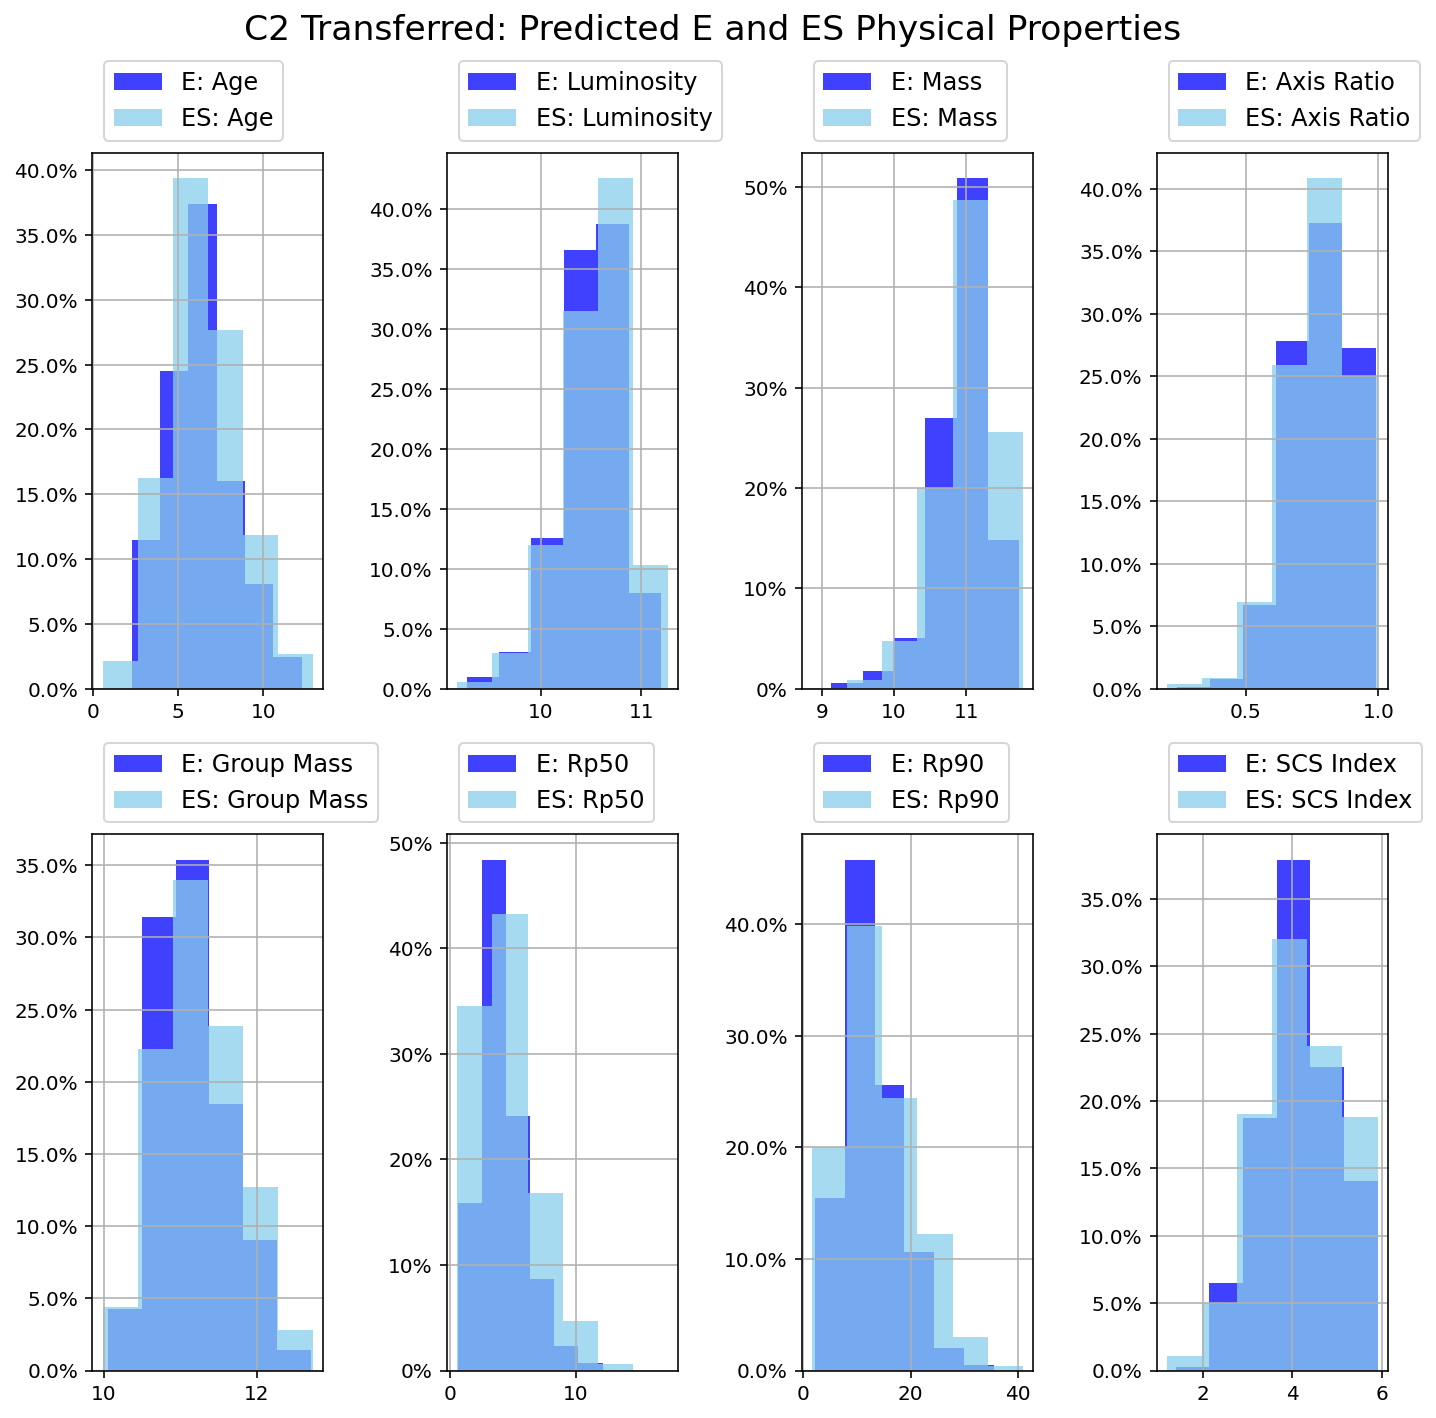

In [23]:
write_phys_prop_table(metadata_nair, C2_NA10_predictions, properties_to_investigate, "C2 Transferred")

plot_phys_prop_hists(metadata_nair, C2_NA10_predictions, properties_to_investigate, "C2 Transferred")

## Gamornet Transferred

Physical Property  \
Age in Gyr                                                            Age in Gyr   
Luminosity in g' band in solar unit          Luminosity in g' band in solar unit   
Mass in Log units                                              Mass in Log units   
Axis Ratio (b/a)                                                Axis Ratio (b/a)   
Group Mass in Log units                                  Group Mass in Log units   
Rp50 from SDSS in kiloparsec                        Rp50 from SDSS in kiloparsec   
Rp90 from SDSS in kiloparsec                        Rp90 from SDSS in kiloparsec   
Single component Sersic index in g band  Single component Sersic index in g band   

                                            E Mean    ES Mean  Difference  
Age in Gyr                                6.777973   6.387938    0.390035  
Luminosity in g' band in solar unit      10.534178  10.518795    0.015383  
Mass in Log units                        11.004447  10.991958    0.012489  
Axis Ratio (b/a)                          0.766883   0.784262   -0.017379  
Group Mass in Log units                  11.189617  11.228740   -0.039123  
Rp50 from SDSS in kiloparsec              4.395989   4.426432   -0.030443  
Rp90 from SDSS in kiloparsec             13.375694  13.660876   -0.285182  
Single component Sersic index in g band   4.133335   4.226895   -0.093560

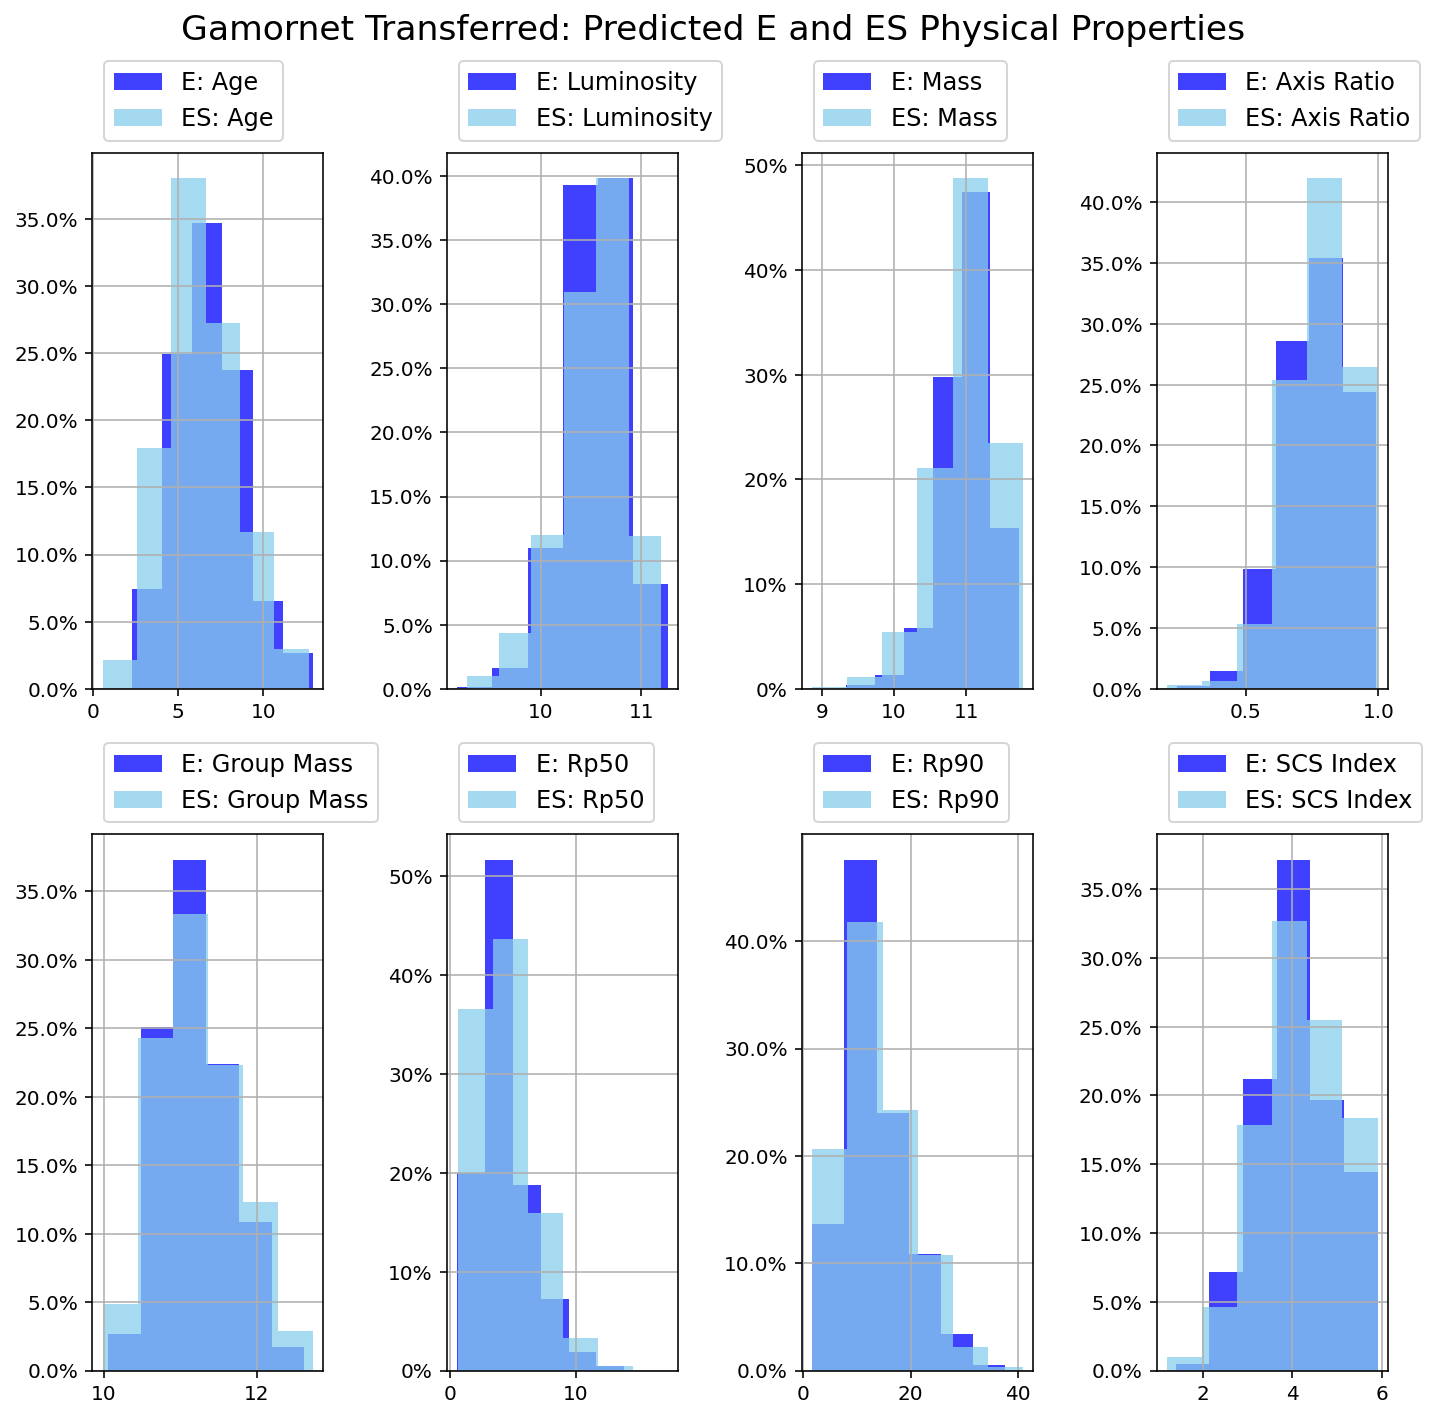

In [24]:
write_phys_prop_table(metadata_nair, Gamornet_NA10_predictions, properties_to_investigate, "Gamornet Transferred")
plot_phys_prop_hists(metadata_nair, Gamornet_NA10_predictions, properties_to_investigate, "Gamornet Transferred")


## C2 Augmented

In [25]:
# C2_Aug_NA10_predictions = c2_califa_model.predict(x_nair).argmax(axis=1)

# write_phys_prop_table(metadata_nair, C2_Aug_NA10_predictions, properties_to_investigate, "C2_Aug")
# plot_phys_prop_hists(metadata_nair, C2_Aug_NA10_predictions, properties_to_investigate, "C2_Aug")


## Gamornet Augmented

In [26]:
# Gamornet_Aug_NA10_predictions = gamornet_califa_model.predict(x_nair).argmax(axis=1)

# write_phys_prop_table(metadata_nair, Gamornet_Aug_NA10_predictions, properties_to_investigate, "Gamornet_Aug")
# plot_phys_prop_hists(metadata_nair, Gamornet_Aug_NA10_predictions, properties_to_investigate, "Gamornet_Aug")



# CNN designs

## C2

In [27]:
plot_model(c2_califa_model, show_shapes=True, show_layer_names=False, expand_nested=True)

NameError: name 'c2_califa_model' is not defined

## Gamornet

In [ ]:
plot_model(gamornet_transferred_model, show_shapes=True, show_layer_names=True, expand_nested=True)

# Convolutional layer visualisations (See keract_d.ipynb)

# TESTING (REMOVE)

In [ ]:
metadata_califa

In [ ]:
metadata_nair

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [1, 2, 3, 4, 5, 6, 7, 8, 9]

x_train, x_test, y_train , y_test = train_test_split(x, y, shuffle=True, train_size=0.8, random_state=2021)

print(x_train)
print(y_train)